# Evaluation of GRN inference methods
## Explanatory analysis
### by Jalil Nourisa



# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tqdm
import json
import warnings
import matplotlib
import sys
import requests
import seaborn as sns
from scipy.stats import spearmanr
import gseapy as gp
import scanpy as sc 
from scipy.sparse import csr_matrix



# from mplfonts import use_font

sys.path.append('../../')
from grn_benchmark.src.helper import surragate_names
from task_grn_inference.src.utils.util import colors_blind
from task_grn_inference.src.exp_analysis.helper import *


controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']

task_grn_inference_dir = '../../task_grn_inference'
results_folder = '../results_folder/'
perturb_col = 'perturbation'

plt.rcParams['font.family'] = 'Liberation Sans'
default_font = matplotlib.rcParams['font.family']
print(default_font)

def binarize_weight(weight):
    if weight > 0:
        return 1
    elif weight < 0:
        return -1
    else:
        return 0
datasets = ['op', 'replogle2', 'nakatake', 'norman', 'adamson']

all_models = ['negative_control', 'positive_control', 'pearson_corr', 'ppcor', 'portia', 'grnboost2', 'scenic', 'scglue', 'celloracle', 'figr', 'granie', 'scenicplus']
all_models = [surragate_names.get(name,name) for name in all_models]
color_map_methods = {key:color for key, color in zip(all_models, sns.color_palette('Set2', len(all_models)))}

# Assign each method a different linestyle
import itertools
line_styles = ['-', '--', '-.', ':']
linestyle_map_methods = {key: linestyle for key, linestyle in zip(all_models, itertools.cycle(line_styles))}


%matplotlib inline

['Liberation Sans']


In [4]:
# panglao_df = pd.read_csv('../output/PanglaoDB_markers_27_Mar_2020.tsv.gz', sep='\t')
# panglao_df = panglao_df[panglao_df.species.isin(['Mm Hs','Hs'])]
# panglao_df['cell type'].nunique()

# Dataset overview

In [18]:
for dataset in datasets: 
    print(f'----inference {dataset}---')
    inference_dataset = ad.read_h5ad(f'{task_grn_inference_dir}/resources/inference_datasets/{dataset}_rna.h5ad')
    print('sample count: ', len(inference_dataset),'gene count: ', inference_dataset.var_names.nunique())
    if 'perturbation' in inference_dataset.obs:
        print('pertub count: ', inference_dataset.obs['perturbation'].nunique())

    print(f'----evaluation {dataset}---')
    perturbation_data = ad.read_h5ad(f'{task_grn_inference_dir}/resources/evaluation_datasets/{dataset}_perturbation.h5ad')
    print('sample count: ', len(perturbation_data),'gene count: ', perturbation_data.var_names.nunique(), 'pertub count: ', perturbation_data.obs['perturbation'].nunique())

----inference op---
sample count:  25551 gene count:  22787
----evaluation op---
sample count:  2170 gene count:  15215 pertub count:  138
----inference replogle2---
sample count:  8869 gene count:  8244
pertub count:  7880
----evaluation replogle2---
sample count:  2072 gene count:  8244 pertub count:  2049
----inference nakatake---
sample count:  454 gene count:  25090
pertub count:  231
----evaluation nakatake---
sample count:  456 gene count:  25090 pertub count:  232
----inference norman---
sample count:  44710 gene count:  5045
pertub count:  116
----evaluation norman---
sample count:  115 gene count:  5045 pertub count:  115
----inference adamson---
sample count:  32223 gene count:  5060
pertub count:  17
----evaluation adamson---
sample count:  65 gene count:  5060 pertub count:  65


In [3]:
# - perturbation effect 
def determine_fold_change_effect(adata, layer = 'X_norm'):
    results = []

    obs_all = adata.obs.reset_index(drop=True)
    X_all = adata.layers[layer]

    if 'cell_type' not in obs_all:
        obs_all['cell_type'] = 'celltype'
        
    for cell_type in obs_all.cell_type.unique():
        mask_celltype = obs_all.cell_type == cell_type

        obs = obs_all.loc[mask_celltype, :]
        X = X_all[mask_celltype, :]


        # - Compute absolute fold change for each gene compared to control group
        # control_indices = obs.index[obs['is_control']].tolist()
        control_matrix = X[obs['is_control'], :]
        control_mean_expression = np.mean(control_matrix, axis=0)
        control_std_expression = np.std(control_matrix, axis=1).mean()
        
        # - Group by unique perturbation samples
        for perturbation in obs['perturbation'].unique():
            group_indices = obs['perturbation']==perturbation
            sample_matrix = X[group_indices, :]  # Subset the gene expression data
            mean_expression = np.mean(sample_matrix, axis=0)  # Mean expression per gene for this sample
            std_expression = np.std(sample_matrix, axis=1).mean()  # Mean expression per gene for this sample
            # - calculate fold change
            mask = control_mean_expression != 0
            fold_change = (mean_expression[mask])/(control_mean_expression[mask])

            # - calulcate std 
            std_change = (std_expression)/(control_std_expression)

            # Store the results for each perturbation
            results.append({'perturbation': perturbation, 'Expression fold change': np.abs(fold_change).mean(), 'STD fold change': std_change, 'cell_type':cell_type})

    results = pd.DataFrame(results)

    return results
perturbation_dict = {}
for i, dataset in enumerate(datasets): 
    adata = ad.read_h5ad(f'{task_grn_inference_dir}/resources/datasets_raw/{dataset}_bulked.h5ad')
    print(dataset, ' number of perrutbation: ', adata.obs['perturbation'].nunique())
    perturbation_dict[dataset] = adata
    # - determine effect size
    perturb_effect_df = determine_fold_change_effect(adata)
    perturb_effect_df['Dataset'] = dataset
    perturb_effect_df['pertub_effect'] = round(np.std(adata.layers['X_norm'], axis=0).mean()/np.std(adata.layers['X_norm'], axis=1).mean(), 2)
    if i == 0:
        perturb_effect_all = perturb_effect_df
    else:
        perturb_effect_all = pd.concat([perturb_effect_all, perturb_effect_df], axis=0)
perturb_effect_all.to_csv('../results_folder/perturb_effect_all.csv')

op  number of perrutbation:  138


/home/jnourisa/miniconda3/envs/py10/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


replogle2  number of perrutbation:  9722
nakatake  number of perrutbation:  463
norman  number of perrutbation:  231
adamson  number of perrutbation:  82


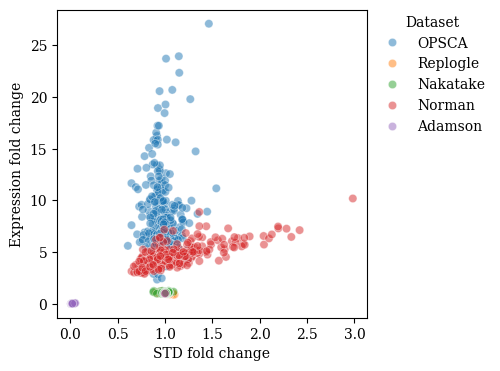

In [86]:
# - perturbation effect 
perturb_effect_all['Dataset'] = perturb_effect_all['Dataset'].map(lambda name: surragate_names.get(name,name))
fig, ax = plt.subplots(1, 1, figsize=(4,4))
sns.scatterplot(perturb_effect_all, x='STD fold change', y='Expression fold change', hue='Dataset', alpha=.5, ax=ax)
legend = ax.legend(bbox_to_anchor=(1.4, 1), loc='upper right', borderaxespad=0, frameon=False)
legend.set_title("Dataset") 

In [87]:
# - set perturbation type 
perturb_effect_all['Perturbation type'] = perturb_effect_all['Dataset'].map({'OPSCA':'Chemical', 'Nakatake': 'Overexpression', 'Norman': 'Activation', 'Adamson':'KD', 'Replogle': 'KD'})

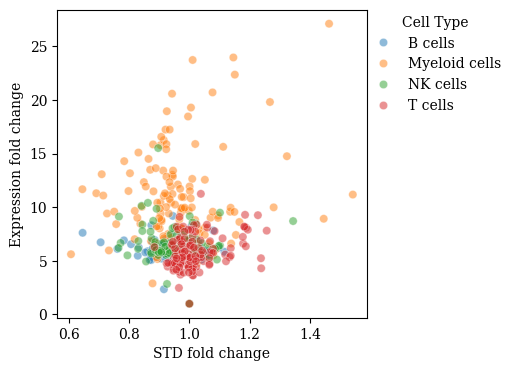

In [88]:
# - perturbation effect 
fig, ax = plt.subplots(1, 1, figsize=(4,4))
sns.scatterplot(perturb_effect_all[perturb_effect_all['Dataset']=='OPSCA'], x='STD fold change', y='Expression fold change', hue='cell_type', alpha=.5, ax=ax)
legend = ax.legend(bbox_to_anchor=(1.45, 1), loc='upper right', borderaxespad=0, frameon=False)
legend.set_title("Cell Type") 

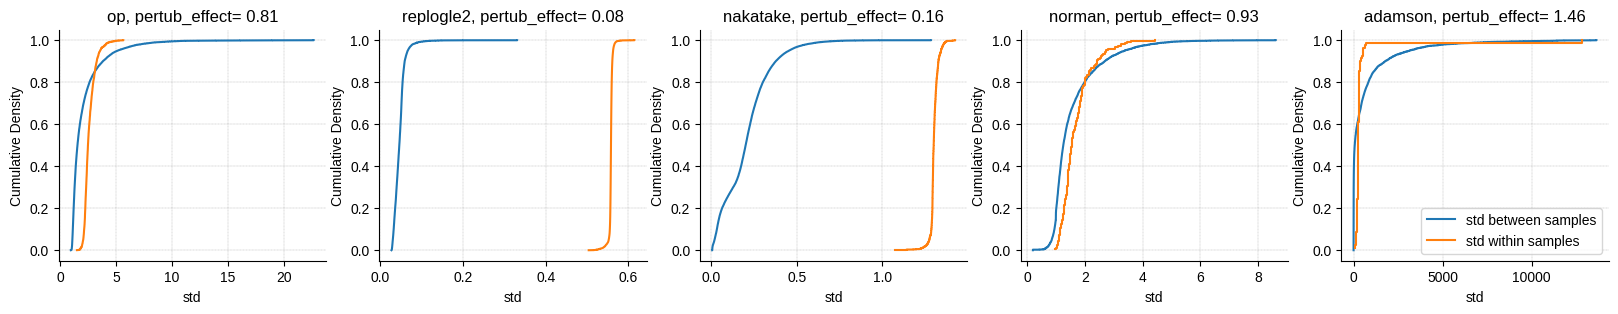

In [6]:
def plot_pertub_effect(adata, layer=None, ax=None, title=''):
    if layer is not None:
        adata.X = adata.layers[layer]
    try:
        y_true = adata.X.todense().A
    except:
        y_true = adata.X
    pertub_effect = round(np.std(y_true, axis=0).mean()/np.std(y_true, axis=1).mean(), 2)

    plot_cumulative_density(np.std(y_true, axis=0), ax=ax, label='std between samples', x_label='std')
    plot_cumulative_density(np.std(y_true, axis=1), ax=ax, label='std within samples',x_label='std')
    ax.set_title(f'{title}, pertub_effect= {pertub_effect:.2f}')

fig, axes = plt.subplots(1, len(datasets), figsize=(4*len(datasets),3))
for i, dataset in enumerate(datasets): 
    layer = 'X_norm'

    ax = axes[i]
    plot_pertub_effect(perturbation_dict[dataset], layer, ax, dataset)
plt.legend()

# Format GRN models

In [45]:
if False: # granie extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/granie_extended.csv')
    net = net[['peak', 'gene']].drop_duplicates().reset_index(drop=True)
    net.columns = ['peak','target']
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/granie.csv')
if False:  # scenicplus extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/output/scenicplus/grn_extended.csv', index_col=0)
    net = net[['peak', 'target']].drop_duplicates().reset_index(drop=True)
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/scenicplus.csv')
if False: # figr extended grn
    net = pd.read_csv(f'{task_grn_inference_dir}/output/figr/cisCorr.csv', index_col=0)
    net = net[['PeakRanges', 'Gene']].drop_duplicates().reset_index(drop=True)
    net.columns = ['peak','target']
    net.to_csv(f'{task_grn_inference_dir}/resources/grn_models/peak_gene/figr.csv')

# Regression 2 n regulators

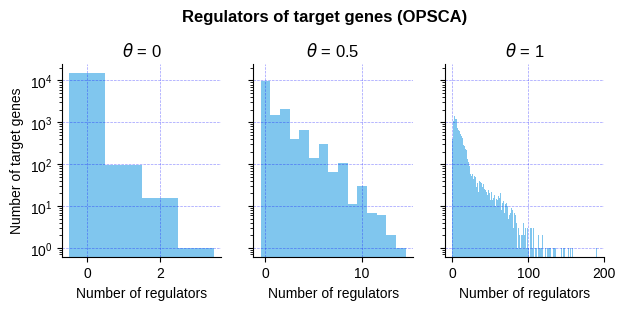

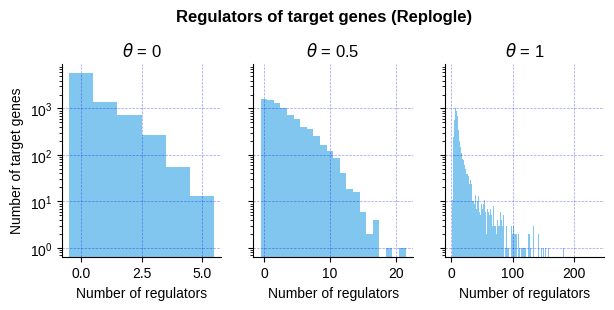

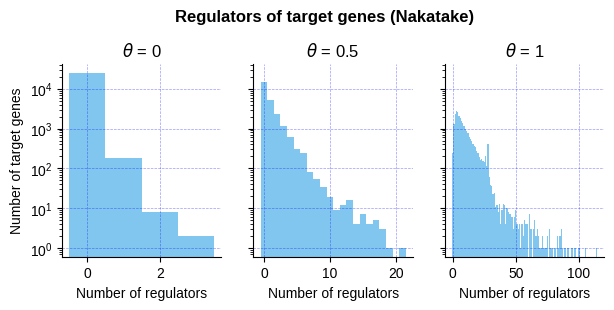

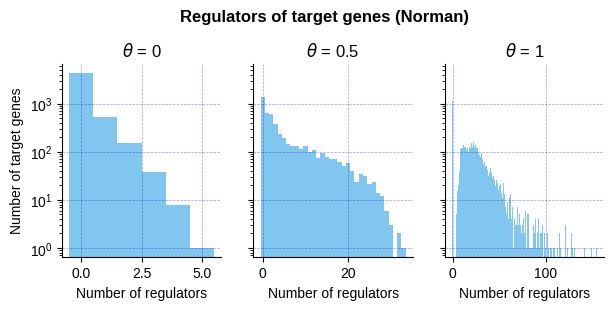

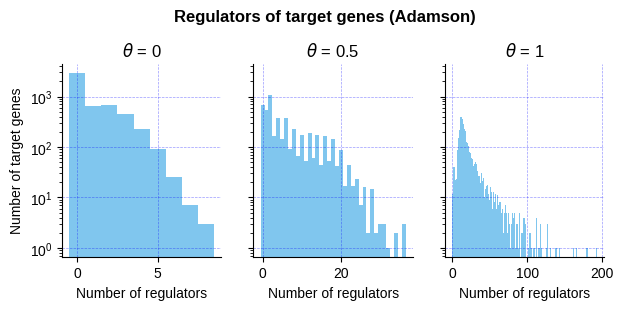

In [5]:
n_genes_with_regulators_dict = {}
for dataset in datasets:
    n_genes_with_regulators_dict[dataset] = []
    
    with open(os.path.join(task_grn_inference_dir, 'resources/prior', f'{dataset}_consensus-num-regulators.json'), 'r') as f:
        data = json.load(f)
    gene_names_ = np.asarray(list(data.keys()), dtype=object)
    n_features = {}
    for theta in ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']:
        n_features[theta] = np.asarray([data[gene_name][theta] for gene_name in gene_names_], dtype=int)
    n_features_dict = {gene_name: i for i, gene_name in enumerate(gene_names_)}
    
    # - plot
    fig, axes = plt.subplots(1,3, figsize=(7, 2.5), sharey=True)

    for i, theta in enumerate(['0', '0.5', '1']):
        n_genes_with_regulators_dict[dataset].append((n_features[theta]!=0).sum())

        ax = axes[i]
        sns.histplot(data=n_features[theta], ax=ax, discrete=True, color='#56B4E9', linewidth=.5, edgecolor=None)
        ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='blue')
        for side in ['right', 'top']:
            ax.spines[side].set_visible(False)
        ax.set_yscale('log')
        # ax.set_xlabel(r'Number of selected regulators')
        ax.set_ylabel('Number of target genes')
        ax.set_title(fr'$\theta$ = {theta}')
        ax.set_xlabel(r'Number of regulators')

    fig.suptitle(f'Regulators of target genes ({surragate_names[dataset]})', y=1.1, fontsize=12, fontweight='bold')

# plt.savefig(f'{results_folder}/benchmark/figs/theta_reg2.png', dpi=300, transparent=True, bbox_inches='tight')
# plt.show()

Text(0.5, 1.0, 'Number of genes with regulators')

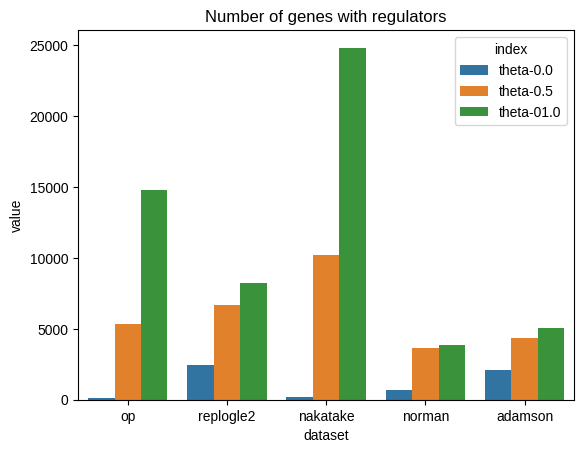

In [21]:
df = pd.DataFrame(n_genes_with_regulators_dict)
df.index = ['theta-0.0', 'theta-0.5', 'theta-01.0']
df = df.reset_index().melt(id_vars = 'index', var_name='dataset')
sns.barplot(df, x='dataset', y='value', hue='index')
plt.title('Number of genes with regulators')

# Enrichment analysis on common TFs


In [ ]:
# - reformat the genesets database
if False:
    panglao_df = pd.read_csv('../output/PanglaoDB_markers_27_Mar_2020.tsv.gz', sep='\t')

    panglao_df = panglao_df[panglao_df.species.isin(['Mm Hs','Hs'])]

    # Open a new file to write the GMT formatted data
    with open("../output/panglaodb_marker_sets.gmt", "w") as gmt_file:
        # Loop through each unique cell type in PanglaoDB
        for cell_type in panglao_df['cell type'].unique():
            # Filter genes for the current cell type
            genes = panglao_df[panglao_df['cell type'] == cell_type]['official gene symbol'].tolist()
            
            # Write the cell type name, description, and genes to the GMT file
            gmt_file.write(f"{cell_type}\tPanglaoDB cell type marker\t" + "\t".join(genes) + "\n")


pearson_corr 50000
grnboost2 50000
scenicplus 41288
granie 50000
ppcor 50000
figr 52962
['ppcor', 'granie', 'scenicplus', 'grnboost2', 'figr', 'pearson_corr']


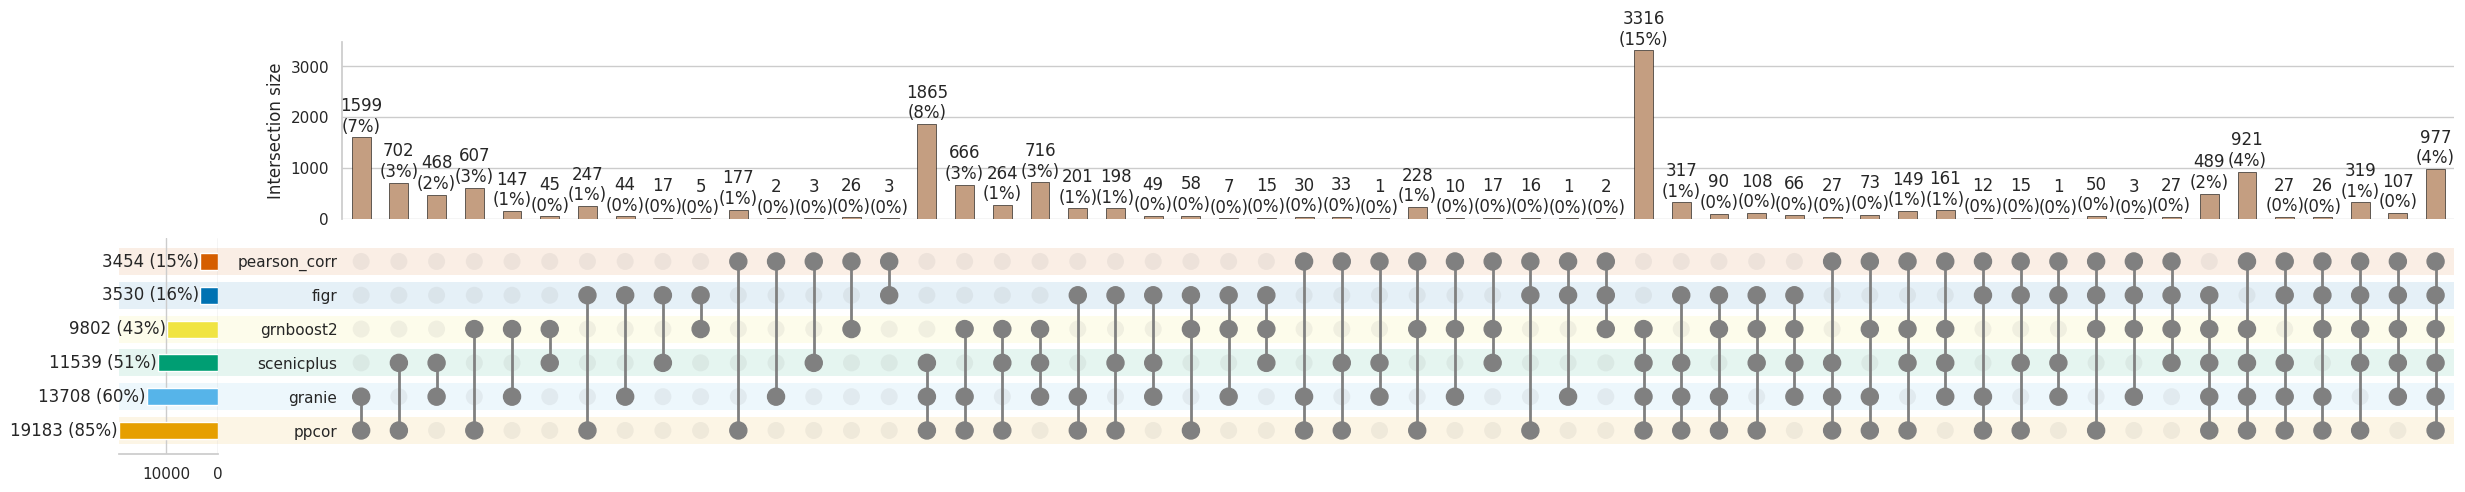

In [124]:
par = {
    'best_performers': ['pearson_corr', 'grnboost2', 'scenicplus'],
    'worse_performers': ['granie', 'ppcor', 'figr'],
    'grn_models_dir': f'{task_grn_inference_dir}/resources/grn_models/op/'

}
exp_objs_dict = {}

for model in par['best_performers']+par['worse_performers']:
    par['grn_model'] = f"{par['grn_models_dir']}/{model}.csv"
    if not os.path.exists(par['grn_model']):
        print(model, ' is skipped')
        continue
    net = pd.read_csv(par['grn_model'])

    print(model, len(net))
    obj = Exp_analysis(net)
    obj.calculate_basic_stats()
    exp_objs_dict[model] = obj


interaction_info = create_interaction_info(exp_objs_dict)
fig = plot_interactions(interaction_info['target'], min_subset_size = 1, min_degree=2, color_map=None) 

common_tfs:  69
                          Term Overlap  Adjusted P-value  \
0   Adipocyte progenitor cells    3/23          0.023412   
4                      B cells    5/98          0.023551   
12                Chondrocytes    4/51          0.023412   
22                 Fibroblasts   6/171          0.044151   
25    Hematopoietic stem cells    5/88          0.023412   
35                 Melanocytes    3/40          0.044151   
36             Mesangial cells    4/57          0.023412   
37             Microfold cells    3/30          0.023551   
42      Natural killer T cells    5/23          0.000208   
46                    Nuocytes    2/12          0.038483   
48  Osteoclast precursor cells     2/8          0.023412   
58              T helper cells    6/60          0.001116   
59              T memory cells    4/55          0.023412   

                                  Genes  
0                    PPARG;GATA3;TCF7L1  
4        PAX5;BACH2;BCL11A;EBF1;POU2AF1  
12               

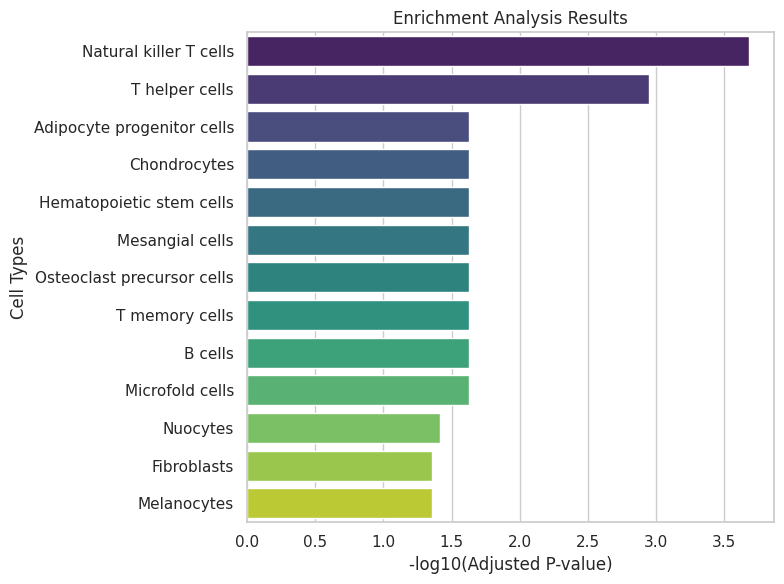

common_tfs:  22
                            Term Overlap  Adjusted P-value            Genes
2                 B cells memory    3/66          0.042309  BACH2;SPIB;IRF8
3                  B cells naive    3/69          0.042309  BACH2;SPIB;IRF8
33  Plasmacytoid dendritic cells    3/55          0.042309   SPIB;ETV6;IRF8


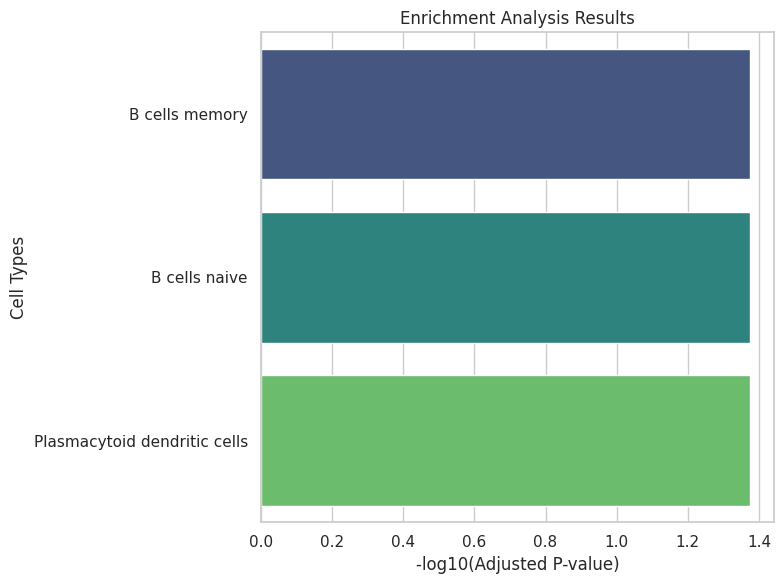

In [125]:
for group in [par['best_performers'], par['worse_performers']]:
    common_tfs = interaction_info['source'][group]
    common_tfs = list(common_tfs[common_tfs.all(axis=1)].index)
    print('common_tfs: ',len(common_tfs))

    # Perform Over-Representation Analysis (ORA)
    enr = gp.enrichr(
        gene_list=common_tfs,     # List of genes
        gene_sets='../output/panglaodb_marker_sets.gmt',  #KEGG_2021_Human 'GO_Biological_Process_2021'
        organism='Human',         # Organism
        outdir='output/enrichr_results', # Output directory
    )

    enrich_rr = enr.results

    enrich_rr = enrich_rr[enrich_rr['Adjusted P-value']<0.05][['Term', 'Overlap', 'Adjusted P-value', 'Genes']]
    print(enrich_rr)

    def plot_enrichment(df):
        # Calculate -log10 of Adjusted P-value for a clearer visualization
        df['-log10(Adjusted P-value)'] = -np.log10(df['Adjusted P-value'])

        # Sort the DataFrame by significance (optional)
        df = df.sort_values(by='-log10(Adjusted P-value)', ascending=False)

        # Plotting the enrichment analysis
        plt.figure(figsize=(8, 6))
        sns.barplot(data=df, y='Term', x='-log10(Adjusted P-value)', palette="viridis")

        # Add plot labels and title
        plt.xlabel("-log10(Adjusted P-value)")
        plt.ylabel("Cell Types")
        plt.title("Enrichment Analysis Results")
        plt.tight_layout()
    plot_enrichment(enrich_rr)
    plt.show()

# Stability analysis and biolgical insights

## Regression 1

In [ ]:
dataset = 'op' #'nakatake' #op', norman


par = {
    'grn_models': ['pearson_corr', 'granie', 'grnboost2', 'scenicplus'],
    'enrichment_models': ['pearson_corr', 'grnboost2', 'scenicplus'],
    # 'grn_models': ['pearson_corr', 'positive_control', 'scenic', 'grnboost2'],
    # 'datasetment_models': ['pearson_corr', 'positive_control', 'grnboost2'],
    'grn_models_dir': f'{task_grn_inference_dir}/resources/grn_models/{dataset}/',
    'evaluation_data': f'{task_grn_inference_dir}/resources/evaluation_datasets/{dataset}_perturbation.h5ad',
    'layer': 'X_norm',
    'consensus':  f'../output/{dataset}_consensus-num-regulators.json',
    'tf_all': f'{task_grn_inference_dir}/resources/prior/tf_all.csv',
    'static_only': False,
    'num_workers': 4,
    'apply_tf': True,
    'apply_skeleton': False,
    'verbose': 2,
    'max_n_links': 50_000
}

exp_objs_dict = {}

for model in par['grn_models']:
    par['grn_model'] = f"{par['grn_models_dir']}/{model}.csv"
    if not os.path.exists(par['grn_model']):
        print(model, ' is skipped')
        continue
    net = pd.read_csv(par['grn_model'])

    print(model, len(net))
    obj = Exp_analysis(net)
    obj.calculate_basic_stats()
    exp_objs_dict[model] = obj


interaction_info = create_interaction_info(exp_objs_dict)
fig = plot_interactions(interaction_info['target'], min_subset_size = 1, min_degree=1, color_map=None) 

In [61]:
# - imports 
sys.path.append('../../task_grn_inference/src/utils')
from task_grn_inference.src.metrics.regression_1.main import main, cross_validation, r2_score, regression_1, process_net

# - read inputs
tf_all = np.loadtxt(f'{task_grn_inference_dir}/resources/prior/tf_all.csv', dtype=str)

perturb_data = ad.read_h5ad(par['evaluation_data'])
if par['layer'] == 'X':
    pass
else:
    perturb_data.X = perturb_data.layers[par['layer']]
gene_names = perturb_data.var_names

In [62]:
# - calculate the scores and feature importance 
if False:
    scores_store = []

    if 'donor_id' not in perturb_data.obs:
        perturb_data.obs['donor_id'] = 'donor_one'
        perturb_data.obs['cell_type'] = 'cell_type'

    i_iter = 0
    for reg_type in ['ridge']:
        for donor_id in perturb_data.obs.donor_id.unique():
            perturb_data_sub = perturb_data[perturb_data.obs.donor_id == donor_id]
            # perturb_data_sub = perturb_data_sub[:5, :] #TODO: remove this
            obs = perturb_data_sub.obs.reset_index(drop=True)

            for i_model, model in enumerate(par['grn_models']):
                net = pd.read_csv(f"{par['grn_models_dir']}/{model}.csv")
                
                results = cross_validation(net, perturb_data_sub, par={'exclude_missing_genes':False, 'reg_type':reg_type, 'verbose':3, 'num_workers':20})

                reg_models = results['reg_models']
                r2score_samples = results['r2scores']                

                if reg_type == 'ridge':
                    coeffs = [reg.coef_ for reg in reg_models]
                else:
                    coeffs = [reg.get_feature_importance() for reg in reg_models]

                # - mean of feature importance across CVs
                net_mat = process_net(net.copy(), gene_names)
                mean_coeff = pd.DataFrame(
                    np.mean(coeffs, axis=0),
                    columns=net_mat.columns,
                    index=pd.MultiIndex.from_frame(obs[[perturb_col, 'cell_type']])
                )    
                # - normalize feature importance for each sample
                mean_coeff = mean_coeff.abs()
                mean_coeff = mean_coeff.div(mean_coeff.max(axis=1), axis=0)
                
                # - long df for feature importance 
                mean_coeff  = mean_coeff.reset_index()
                mean_coeff = mean_coeff.melt(id_vars=[perturb_col, 'cell_type'], var_name='tf', value_name='feature_importance')
                mean_coeff['model'] = model
                mean_coeff['donor_id'] = donor_id
                mean_coeff['reg_type'] = reg_type

                if i_iter == 0:
                    feature_importance_all = mean_coeff
                else:
                    feature_importance_all = pd.concat([feature_importance_all, mean_coeff], axis=0)

                for i_sample, score_sample in enumerate(r2score_samples):
                    scores_store.append({
                        'reg_type': reg_type,
                        'donor_id':donor_id,
                        'r2score':score_sample,
                        'model': model,
                        'cell_type': obs.loc[i_sample]['cell_type'],
                        perturb_col: obs.loc[i_sample][perturb_col]
                    })
                i_iter+=1
                
    scores_store = pd.DataFrame(scores_store)
    scores_store.to_csv(f'../results_folder/{dataset}_scores_store.csv')
    feature_importance_all.to_csv(f'../results_folder/{dataset}_feature_importance.csv')

In [63]:
# - retireive data and subset to one reg type
reg_type = 'ridge'

scores_store_all = pd.read_csv(f'../results_folder/{dataset}_scores_store.csv', index_col=0)
feature_importance_all = pd.read_csv(f'../results_folder/{dataset}_feature_importance.csv', index_col=0)

scores_store_all.rename(columns={'sm_name':'perturbation'}, inplace=True)
feature_importance_all.rename(columns={'sm_name':'perturbation'}, inplace=True)
scores_store = scores_store_all[scores_store_all.reg_type==reg_type]

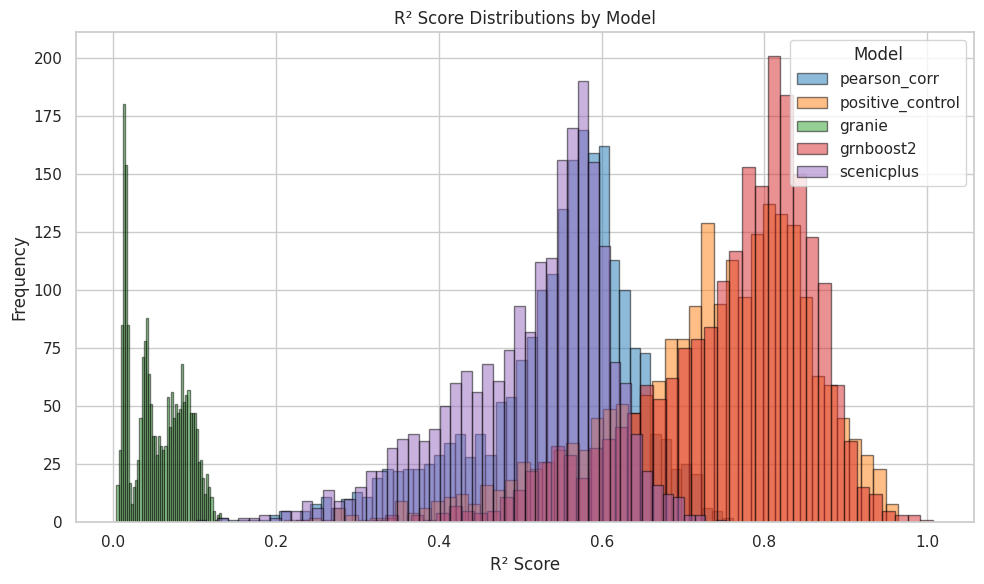

In [64]:
plt.figure(figsize=(10, 6))

# Get unique models and define colors
models = scores_store_all['model'].unique()
colors = plt.cm.tab10(range(len(models)))  # Use a colormap for unique colors

# Plot histograms for each model
for model, color in zip(models, colors):
    subset = scores_store_all[scores_store_all['model'] == model]
    plt.hist(subset['r2score'], bins=50, alpha=0.5, label=model, color=color, edgecolor='black')

# Add legend and labels
plt.title("R² Score Distributions by Model")
plt.xlabel("R² Score")
plt.ylabel("Frequency")
plt.legend(title="Model")
plt.tight_layout()

# Show the plot
plt.show()

### Consistency across donors

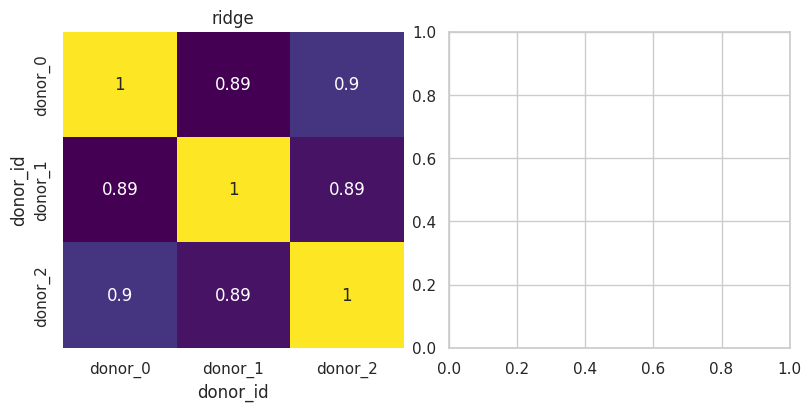

In [65]:
if dataset in ['op']:
    # Create a 1x2 subplot layout
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

    # Loop over the regression types and plot each heatmap on a separate subplot
    for idx, reg_type in enumerate(['ridge']):
        # Filter data based on reg_type
        scores_store = scores_store_all[scores_store_all['reg_type'] == reg_type]

        # scores_store = scores_store.loc[scores_store.model.isin(['pearson_corr', 'positive_control', 'grnboost2', 'scenicplus']), :]
        
        # Create pivot table
        scores_store_table = scores_store.pivot_table(
            index='donor_id', 
            values='r2score', 
            columns=[col for col in scores_store.columns if col not in ['donor_id', 'r2score']]
        ).fillna(0)
        
        # Calculate the Spearman correlation matrix
        corr_matrix = scores_store_table.T.corr(method='spearman')
        
        # Plot heatmap on the appropriate subplot axis
        sns.heatmap(corr_matrix, annot=True, cmap="viridis", cbar=False, ax=axes[idx])
        axes[idx].set_title(f'{reg_type}')

    # Show the plot
    plt.show()

### Similarity in performance across models

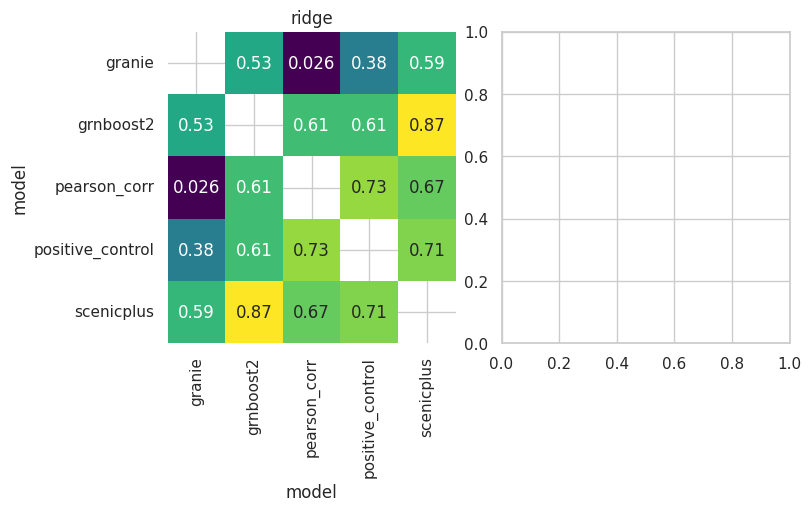

In [66]:

fig, axes = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)

# Loop over regression types to generate each heatmap on separate subplots
for idx, reg_type in enumerate(['ridge']):
    # Filter data for the current reg_type
    scores_store = scores_store_all[scores_store_all['reg_type'] == reg_type]
    if scores_store.shape[0]==0:
        continue
    
    # Create a pivot table using 'model' as the index
    scores_store_table = scores_store.pivot_table(
        index='model', 
        values='r2score', 
        columns=[col for col in scores_store.columns if col not in ['model', 'r2score']]
    ).fillna(0)
    
    # Calculate the Spearman correlation matrix
    spearman_corr = scores_store_table.T.corr(method='spearman')
    
    # Set the diagonal values to NaN for better visualization
    np.fill_diagonal(spearman_corr.values, np.nan)
    
    # Plot the heatmap on the corresponding subplot
    sns.heatmap(spearman_corr, annot=True, cmap="viridis", cbar=False, ax=axes[idx])
    axes[idx].set_title(f'{reg_type}')

# Show the plots
plt.show()

### Performance segregated by cell types


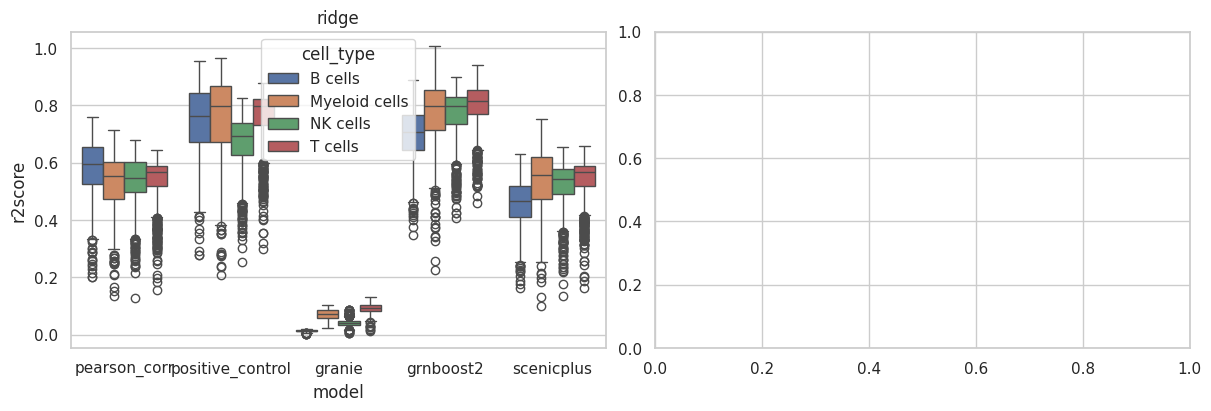

In [67]:
if dataset in ['op']:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    # Loop over regression types to generate each heatmap on separate subplots
    for idx, reg_type in enumerate(['ridge']):
        # Filter data for the current reg_type
        scores_store = scores_store_all[scores_store_all['reg_type'] == reg_type]
        
        sns.boxplot(data=scores_store, x="model", y="r2score", hue="cell_type", ax=axes[idx])
        axes[idx].set_title(f'{reg_type}')


### Performacne segragated by PC and NC samples

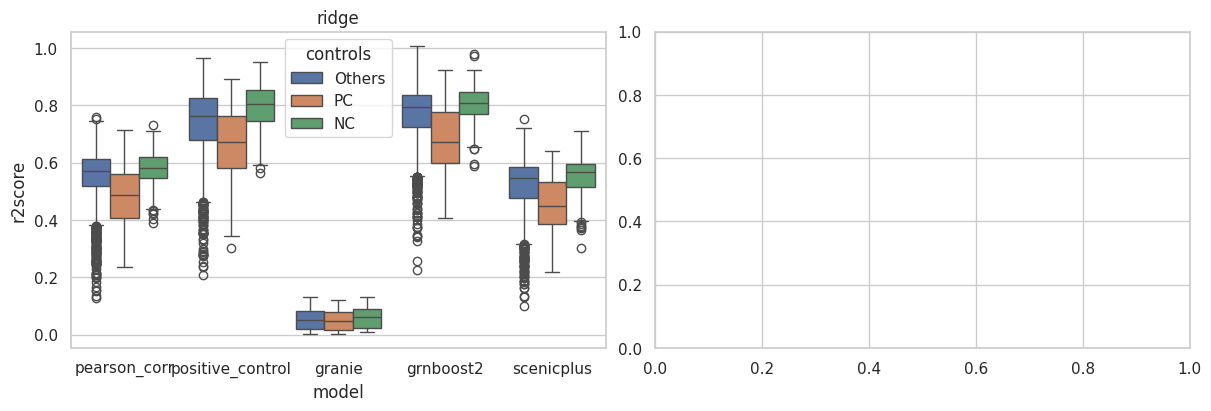

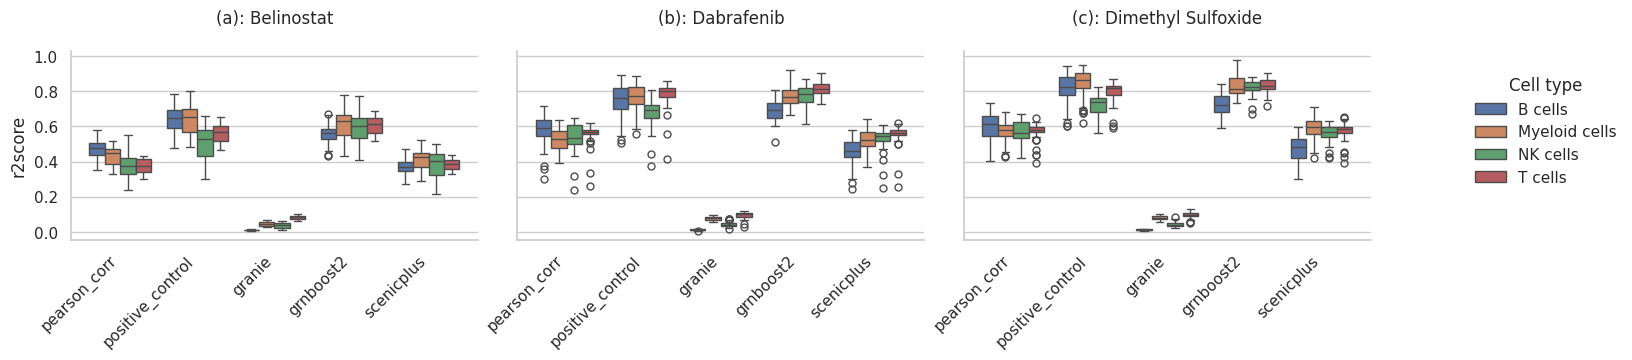

In [68]:
if dataset in ['op']:
    scores_store_all['controls'] = 'Others'
    mask_pc = scores_store_all.perturbation.isin(['Dabrafenib', 'Belinostat'])
    scores_store_all.loc[mask_pc, 'controls'] = 'PC'
    mask_nc = scores_store_all.perturbation.isin(['Dimethyl Sulfoxide'])
    scores_store_all.loc[mask_nc, 'controls'] = 'NC'

    scores_store_controls = scores_store_all[scores_store_all.perturbation.isin(controls3)]

    # - plot for all cell types
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    # Loop over regression types to generate each heatmap on separate subplots
    for idx, reg_type in enumerate(['ridge']):
        # Filter data for the current reg_type
        scores_store = scores_store_all[scores_store_all['reg_type'] == reg_type]
        
        sns.boxplot(data=scores_store, x="model", y="r2score", hue="controls", ax=axes[idx])
        axes[idx].set_title(f'{reg_type}')

    plt.show()

    # - plot cell type specific 
    g = sns.catplot(
        data=scores_store_controls, 
        x='model', 
        y=r'r2score', 
        hue='cell_type', 
        col='perturbation', 
        kind='box',
        height=3, 
        # width=6, 
        aspect=1.4,
        # palette=colors_cell_type,
        legend_out=True
    )
    # Rotate the x-axis labels for all subplots
    for ax in g.axes.flatten():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')
    # Adjust the position of the legend to the right
    g._legend.remove()
    g.add_legend(title="Cell type", bbox_to_anchor=(.95, 0.6), loc='center left')
    prefixes = ['(a)', '(b)', '(c)']
    for i, ax in enumerate(g.axes.flat):
        sub_title = ax.get_title().replace('perturbation = ', f'{prefixes[i]}: ').strip()  # Remove 'Type='
        ax.set_title(sub_title, pad=20, fontsize=12)

        ax.margins(x=0.05)
    # plt.suptitle(title, y=1.2,  fontsize=12, fontweight='bold')

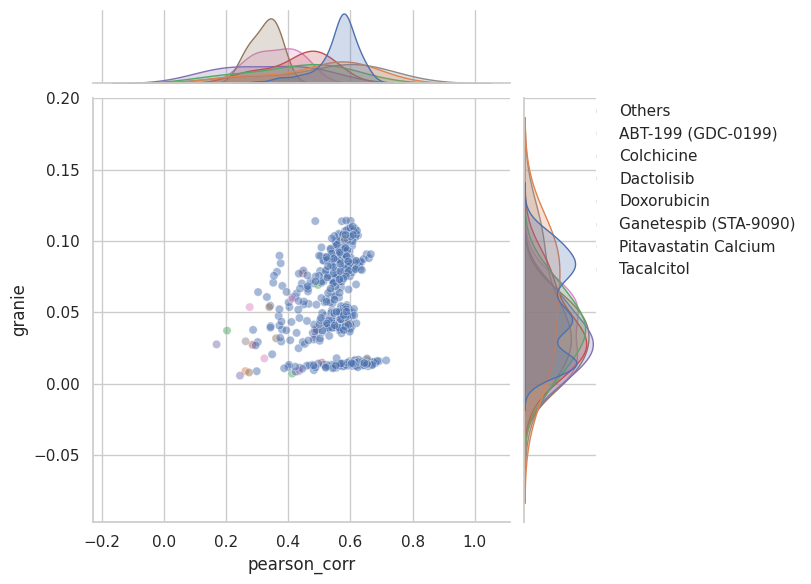

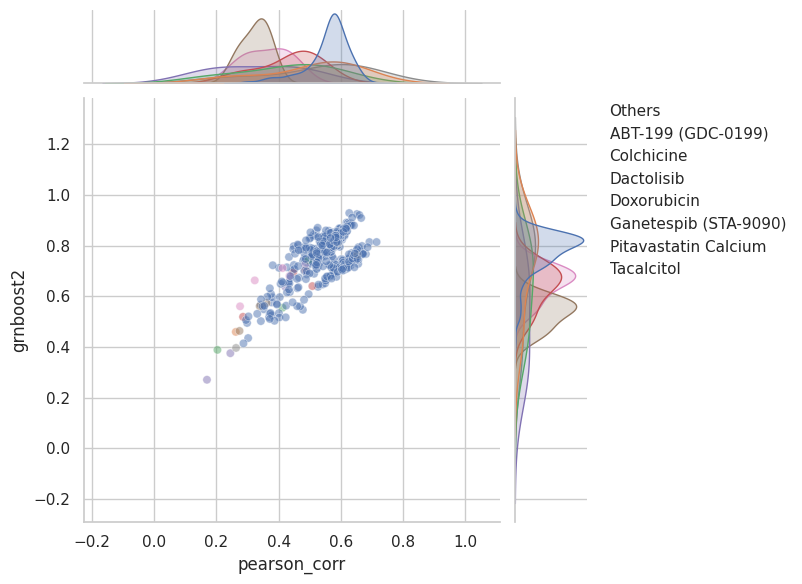

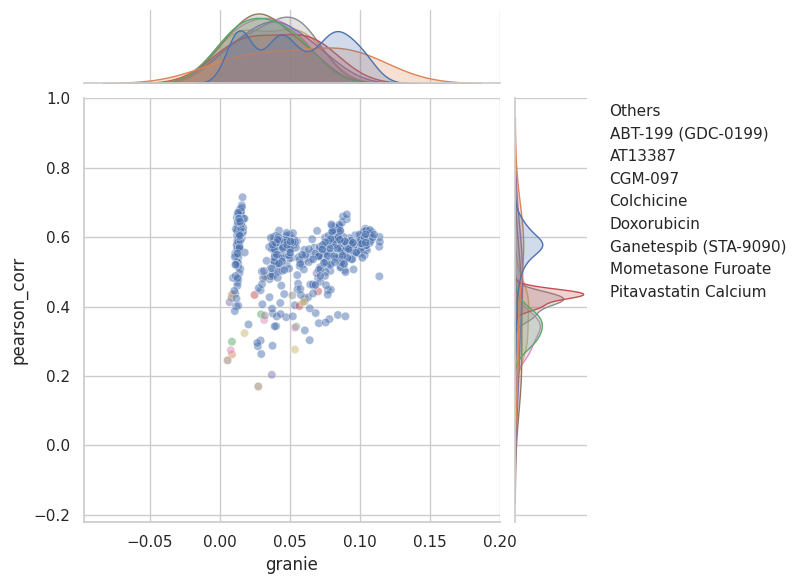

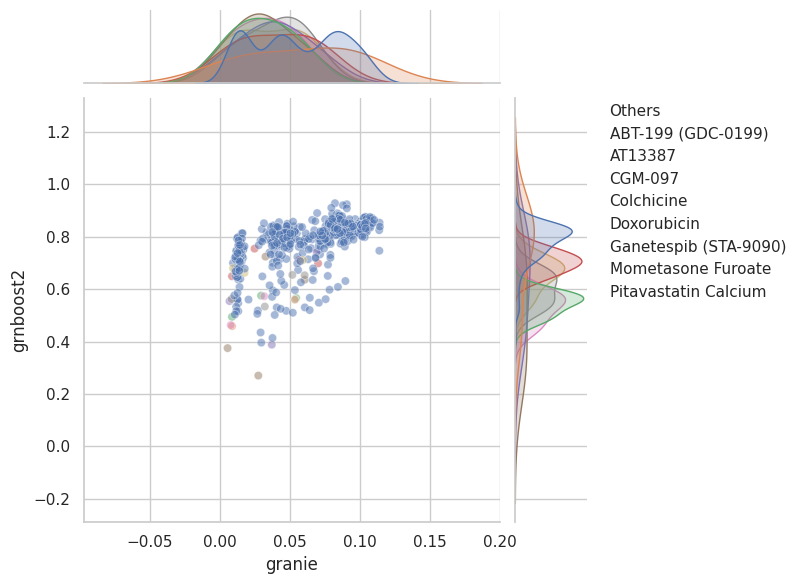

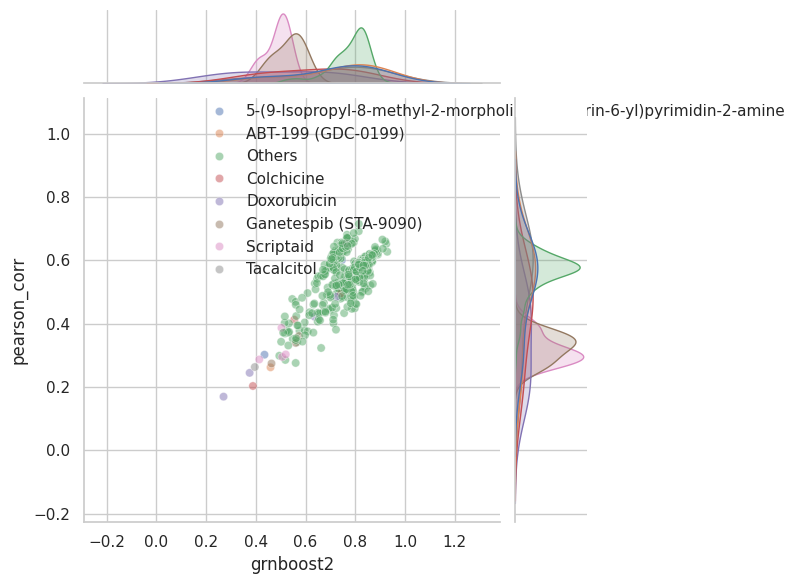

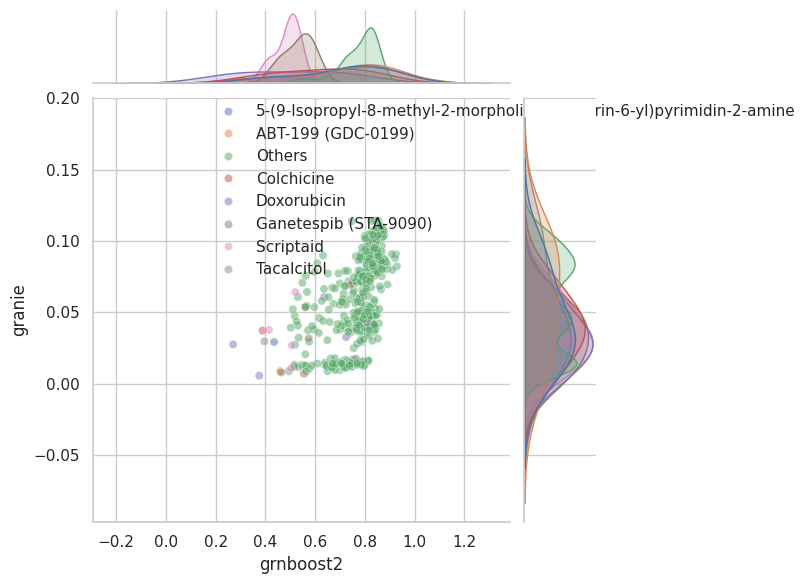

In [69]:
# - joint plot
if dataset == 'op':
    # Aggregate the data to handle duplicates
    subset_df_agg = scores_store.groupby(['perturbation', 'cell_type', 'model'], as_index=False)['r2score'].mean()
    pivot_df = subset_df_agg.pivot(index=['perturbation', 'cell_type'], columns='model', values='r2score')
else:
    subset_df_agg = scores_store.groupby([perturb_col, 'model'], as_index=False)['r2score'].mean()
    pivot_df = subset_df_agg.pivot(index=[perturb_col], columns='model', values='r2score')
    pass


def plot_joint(pivot_df, x_name, y_name):
    
    low_score_compounds = pivot_df[[perturb_col, x_name, y_name]].sort_values(by=[x_name, y_name]).head(8)
    low_score_mask = pivot_df[perturb_col].isin(low_score_compounds[perturb_col])
    low_scoring_samples = pivot_df[low_score_mask][perturb_col].unique()

    pivot_df['perturb_filter'] = 'Others'
    
    pivot_df.loc[low_score_mask, 'perturb_filter'] = pivot_df.loc[low_score_mask, perturb_col]

    sns.jointplot(
        data = pivot_df, 
        x = f"{x_name}", 
        y = f"{y_name}", 
        hue='perturb_filter',   # Color points by "True"/"False"
        # style='cell_type',
        # markers=True,
        # kind="kde",    # Contours with kde
        # fill=False,    # Fill contour lines
        marginal_kws=dict(common_norm=False, fill=True),  # Marginal distribution,
        alpha=.5
    )
    legend = plt.legend(bbox_to_anchor=(1.7, 1), loc='upper right', borderaxespad=0, frameon=False)

    plt.xlabel(x_name)
    plt.ylabel(y_name)
    # plt.legend(loc=(1.3, .2))
    return low_scoring_samples
low_scoring_samples_store = []
for i in range(3):
    for j in range(3):
        if i == j:
            continue
        name1 = par['grn_models'][i]
        name2 = par['grn_models'][j]
        
        low_scoring_samples = plot_joint(pivot_df.reset_index(), x_name=name1, y_name=name2)

        if (name1=='granie') | (name2=='granie'):
            pass
        else:
            low_scoring_samples_store.append(low_scoring_samples)


In [70]:
low_scoring_samples_intersect = np.intersect1d(low_scoring_samples_store[0], low_scoring_samples_store[1])
low_scoring_samples_intersect

array(['ABT-199 (GDC-0199)', 'Colchicine', 'Doxorubicin',
       'Ganetespib (STA-9090)', 'Tacalcitol'], dtype=object)

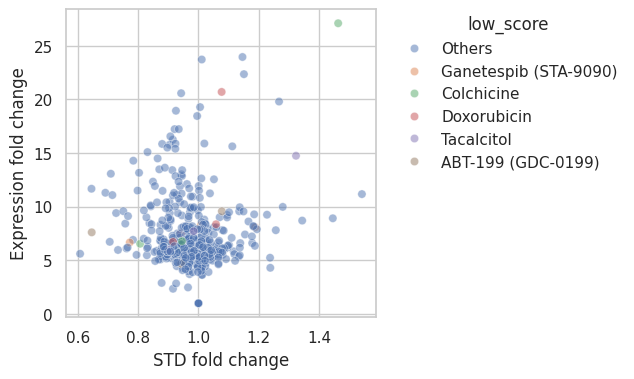

In [71]:
low_scoring_samples = np.concatenate(low_scoring_samples_store)
perturb_effect_all = pd.read_csv('../results_folder/perturb_effect_all.csv')
perturb_effect_all = perturb_effect_all[perturb_effect_all['Dataset']=='op']
low_score_mask = perturb_effect_all['perturbation'].isin(low_scoring_samples_intersect)

perturb_effect_all['perturbation_subset'] = 'Others'
perturb_effect_all.loc[low_score_mask, 'perturbation_subset'] = perturb_effect_all.loc[low_score_mask, 'perturbation']

fig, ax = plt.subplots(1, 1, figsize=(4,4))
sns.scatterplot(perturb_effect_all, x='STD fold change', y='Expression fold change', hue='perturbation_subset', alpha=.5, ax=ax)
legend = ax.legend(bbox_to_anchor=(1.8, 1), loc='upper right', borderaxespad=0, frameon=False)
legend.set_title("low_score") 

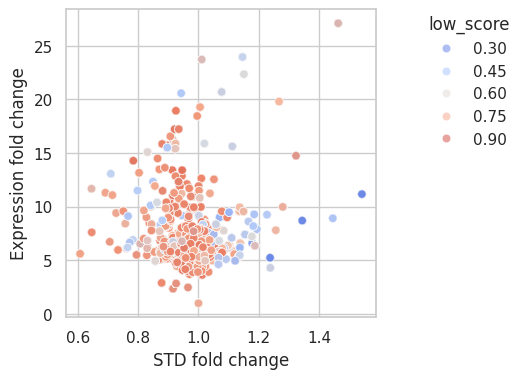

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
cmap = sns.color_palette("coolwarm", as_cmap=True)

scores_store_sub = scores_store[scores_store['model']=='positive_control'][['perturbation','r2score']].rename(columns={'perturbation':'perturbation'})

perturb_effect_all = perturb_effect_all.merge(scores_store_sub, on='perturbation')

sns.scatterplot(perturb_effect_all, x='STD fold change', y='Expression fold change', hue='r2score', alpha=.5, ax=ax, palette=cmap)
legend = ax.legend(bbox_to_anchor=(1.45, 1), loc='upper right', borderaxespad=0, frameon=False)
legend.set_title("low_score") 

### Feature importance: similarity across models

In [73]:
# - model specific feature importance -> only intersections 
def lambda_func(df):
    return df['feature_importance'].values.flatten()

feature_importance = feature_importance_all[feature_importance_all.reg_type == reg_type].drop(columns=['reg_type'])
# feature_importance
df_pivot = feature_importance.groupby('model').apply(lambda_func)
df_pivot = pd.DataFrame(df_pivot.tolist(), index=df_pivot.index)
df_pivot.T.corr(method='spearman').style.background_gradient()

In [74]:
# - feature importance preservation across donors  -> only intersections 
def lambda_func(df):
    return df['feature_importance'].values.flatten()

feature_importance = feature_importance_all[feature_importance_all.reg_type == reg_type].drop(columns=['reg_type'])
# feature_importance
df_pivot = feature_importance.groupby('donor_id').apply(lambda_func)
df_pivot = pd.DataFrame(df_pivot.tolist(), index=df_pivot.index)
df_pivot.T.corr(method='spearman').style.background_gradient()

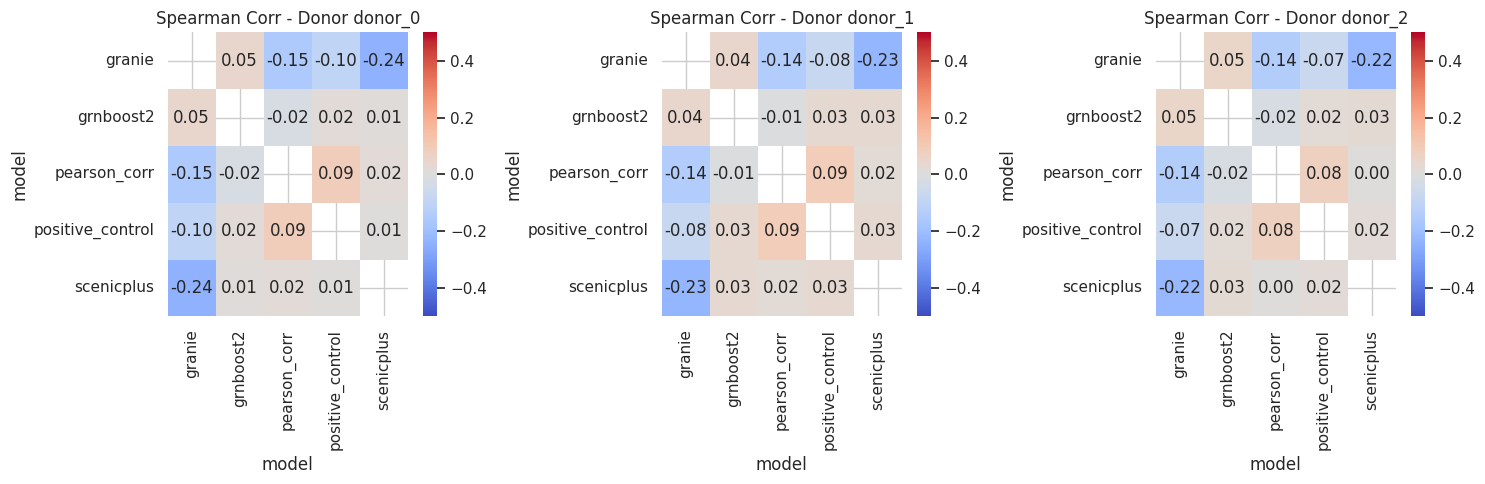

In [75]:
# - model specific feature importance -> only intersections 
if True:
    def lambda_func(df):
        return df['feature_importance'].values.flatten()
    # for reg_type in ['ridge','GB']:
    # Create a figure with 3 axes
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Iterate over donor_ids
    for idx, donor_id in enumerate(feature_importance.donor_id.unique()):
        df_pivot = feature_importance[feature_importance.donor_id == donor_id].groupby('model').apply(lambda_func)
        df_pivot = pd.DataFrame(df_pivot.tolist(), index=df_pivot.index)
        
        # Calculate Spearman correlation
        spearman_corr = df_pivot.T.corr(method='spearman')
        np.fill_diagonal(spearman_corr.values, np.nan)
        
        # Plot the heatmap on the respective axis
        sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, vmin=-.5, vmax=.5,
                    ax=axes[idx])
        axes[idx].set_title(f'Spearman Corr - Donor {donor_id}')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [76]:
# Pivot with pivot_table and take the mean of duplicates
if dataset in ['op']:
    columns = ['model', 'cell_type', perturb_col, 'donor_id']
else:
    columns = ['model',  perturb_col]

feature_importance_all_sub = feature_importance_all[feature_importance_all.model.isin(par['enrichment_models'])]
feature_importance_common = feature_importance_all_sub.pivot_table(
    index=columns, 
    values='feature_importance', 
    columns='tf',
    aggfunc='mean'  # or 'sum', 'max', etc.
)
feature_importance_common = feature_importance_common.loc[:, ~feature_importance_common.isna().any(axis=0)]
feature_importance_common.head()

tf                                                                                 ARID5B  \
model     cell_type perturbation                                       donor_id             
grnboost2 B cells   5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... donor_0   0.010492   
                                                                       donor_1   0.001174   
                                                                       donor_2   0.019160   
                    ABT-199 (GDC-0199)                                 donor_1   0.040499   
                    AMD-070 (hydrochloride)                            donor_0   0.029516   

tf                                                                                   ATF3  \
model     cell_type perturbation                                       donor_id             
grnboost2 B cells   5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... donor_0   0.018319   
                                                                       donor_1   0.036832   
                                                                       donor_2   0.015294   
                    ABT-199 (GDC-0199)                                 donor_1   0.107742   
                    AMD-070 (hydrochloride)                            donor_0   0.141429   

tf                                                                                  BACH1  \
model     cell_type perturbation                                       donor_id             
grnboost2 B cells   5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... donor_0   0.006505   
                                                                       donor_1   0.011307   
                                                                       donor_2   0.008107   
                    ABT-199 (GDC-0199)                                 donor_1   0.004157   
                    AMD-070 (hydrochloride)                            donor_0   0.009934   

tf                                                                                  BACH2  \
model     cell_type perturbation                                       donor_id             
grnboost2 B cells   5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... donor_0   0.023307   
                                                                       donor_1   0.019061   
                                                                       donor_2   0.017039   
                    ABT-199 (GDC-0199)                                 donor_1   0.020078   
                    AMD-070 (hydrochloride)                            donor_0   0.009381   

tf                                                                                 BCL11A  \
model     cell_type perturbation                                       donor_id             
grnboost2 B cells   5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... donor_0   0.019571   
                                                                       donor_1   0.031517   
                                                                       donor_2   0.004358   
                    ABT-199 (GDC-0199)                                 donor_1   0.029099   
                    AMD-070 (hydrochloride)                            donor_0   0.013438   

tf                                                                                BHLHE41  \
model     cell_type perturbation                                       donor_id             
grnboost2 B cells   5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... donor_0   0.062186   
                                                                       donor_1   0.010807   
                                                                       donor_2   0.030966   
                    ABT-199 (GDC-0199)                                 donor_1   0.035236   
                    AMD-070 (hydrochloride)                            donor_0   0.031837   

tf                                                                                   BNC

In [77]:
# - get the top features with highest sum across all models
numeric_df = feature_importance_common.select_dtypes(include='number')
mean_values_by_tf = numeric_df.groupby(level='tf', axis=1).mean()
top_n_tfs = mean_values_by_tf.mean().nlargest(10).index
print("Top 5 TFs with highest average values:")
print(top_n_tfs)

Top 5 TFs with highest average values:
Index(['ZEB2', 'NFKB1', 'BNC2', 'RUNX3', 'EOMES', 'DRAP1', 'CREB5', 'PPARG',
       'MYBL1', 'BCL11A'],
      dtype='object', name='tf')


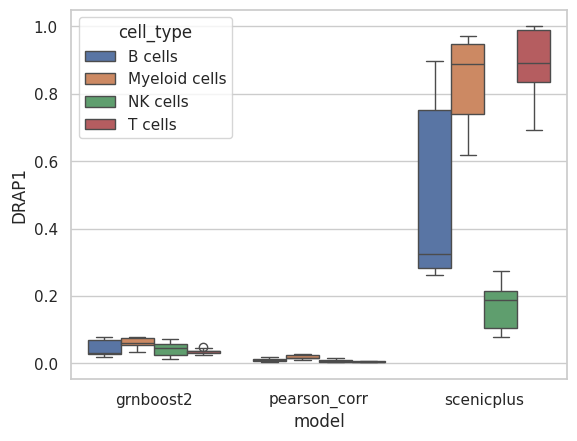

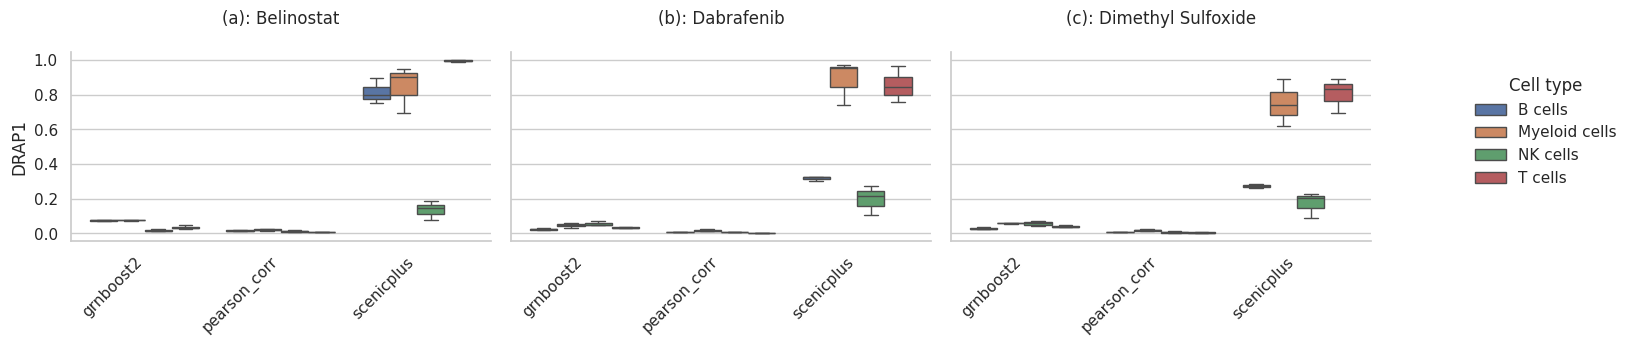

In [78]:
if dataset in ['op']:
    tf = 'DRAP1'
    df_one_tf = feature_importance_common[[tf]].reset_index()
    df_one_tf = df_one_tf[df_one_tf.perturbation.isin(controls3)]
    df_one_tf.perturbation = df_one_tf.perturbation.astype(str)

    sns.boxplot(data=df_one_tf, x="model", y=tf, hue="cell_type")
    plt.show()

    g = sns.catplot(
            data=df_one_tf, 
            x='model', 
            y=tf, 
            hue='cell_type', 
            col='perturbation', 
            kind='box',
            height=3, 
            # width=6, 
            aspect=1.4,
            # palette=colors_cell_type,
            legend_out=True
        )
    # Rotate the x-axis labels for all subplots
    for ax in g.axes.flatten():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xlabel('')
    # Adjust the position of the legend to the right
    g._legend.remove()
    g.add_legend(title="Cell type", bbox_to_anchor=(.95, 0.6), loc='center left')
    prefixes = ['(a)', '(b)', '(c)']
    for i, ax in enumerate(g.axes.flat):
        sub_title = ax.get_title().replace('perturbation = ', f'{prefixes[i]}: ').strip()  # Remove 'Type='
        ax.set_title(sub_title, pad=20, fontsize=12)

        ax.margins(x=0.05)
# plt.suptitle(title, y=1.2,  fontsize=12, fontweight='bold')


Text(0, 0.5, 'Feature importance (mean/std')

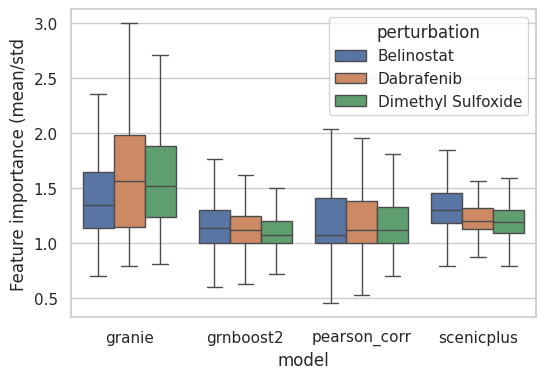

In [117]:
# - feature importance variation across models for control models
feature_importance = feature_importance_all[feature_importance_all.reg_type=='ridge']
df = feature_importance[feature_importance['perturbation'].isin(controls3) & feature_importance['model'].isin(par['grn_models'])]
df = df.groupby(['perturbation','model'])[['tf', 'feature_importance']].apply(lambda df: df.groupby('tf').apply(lambda row: (np.mean(row)+1E-6)/(np.std(row)+1E-6))).reset_index()

plt.figure(figsize=(6,4))
ax = sns.boxplot(df, x='model', y='feature_importance', hue='perturbation', showfliers=False)
ax.set_ylabel('Feature importance (mean/std')

In [80]:
aaaa

NameError: name 'aaaa' is not defined

## Regression 2

positive_control 50000
pearson_corr 50000
grnboost2 50000
ppcor 50000
['ppcor', 'grnboost2', 'pearson_corr', 'positive_control']


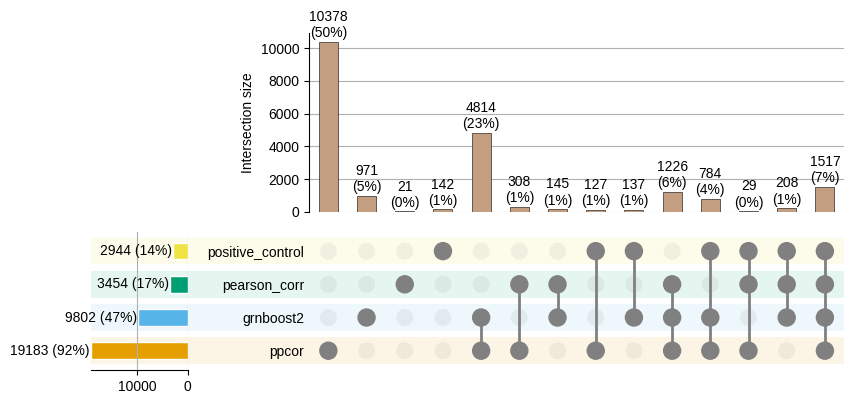

In [2]:
dataset = 'op' #'nakatake' #op', norman


par = {
    'grn_models': ['positive_control', 'pearson_corr', 'grnboost2', 'ppcor'],
    'best_performers': ['pearson_corr', 'positive_control', 'grnboost2'],
    'worse_performers': ['ppcor'],
    'grn_models_dir': f'{task_grn_inference_dir}/resources/grn_models/{dataset}/',
    'evaluation_data': f'{task_grn_inference_dir}/resources/evaluation_datasets/{dataset}_perturbation.h5ad',
    'layer': 'X_norm',
    'consensus':  f'../output/{dataset}_consensus-num-regulators.json',
    'tf_all': f'{task_grn_inference_dir}/resources/prior/tf_all.csv',
    'static_only': False,
    'num_workers': 4,
    'apply_tf': True,
    'apply_skeleton': False,
    'verbose': 2,
    'max_n_links': 50_000
}

exp_objs_dict = {}

for model in par['grn_models']:
    par['grn_model'] = f"{par['grn_models_dir']}/{model}.csv"
    if not os.path.exists(par['grn_model']):
        print(model, ' is skipped')
        continue
    net = pd.read_csv(par['grn_model'])

    print(model, len(net))
    obj = Exp_analysis(net)
    obj.calculate_basic_stats()
    exp_objs_dict[model] = obj


interaction_info = create_interaction_info(exp_objs_dict)
fig = plot_interactions(interaction_info['target'], min_subset_size = 1, min_degree=1, color_map=None) 

### Run the metric

In [3]:
# - imports 
sys.path.append('../../task_grn_inference/src/utils')
from task_grn_inference.src.metrics.regression_2.main import *
# - read inputs
tf_all = np.loadtxt(f'{task_grn_inference_dir}/resources/prior/tf_all.csv', dtype=str)

perturb_data = ad.read_h5ad(par['evaluation_data'])
gene_names = perturb_data.var_names
perturb_data

AnnData object with n_obs × n_vars = 2170 × 15215
    obs: 'cell_type', 'well', 'donor_id', 'row', 'perturbation', 'plate_name', 'cell_count', 'is_control', 'is_positive_control'
    layers: 'X_norm', 'counts', 'lognorm'

In [20]:
# - calculate the scores and feature importance 
if True:
    #- create consensuns
    from task_grn_inference.src.metrics.consensus.script import main
    par['models'] = par['grn_models']
    par['models_dir'] = par['grn_models_dir']
    main(par)

    if 'donor_id' not in perturb_data.obs:
        perturb_data.obs['donor_id'] = 'donor_one'
        perturb_data.obs['cell_type'] = 'cell_type'


    # - run reg
    scores_store = []

    i_iter = 0
    for reg_type in ['ridge']:
        for donor_id in perturb_data.obs.donor_id.unique():
            perturb_data_sub = perturb_data[perturb_data.obs.donor_id == donor_id]
            # perturb_data_sub = perturb_data_sub[:5, :] #TODO: remove this
            obs = perturb_data_sub.obs.reset_index(drop=True)

            for i_model, model in enumerate(par['grn_models']):
                net = pd.read_csv(f"{par['grn_models_dir']}/{model}.csv")
                
                net_matrix = net_to_matrix(net, gene_names, par)

                n_cells = perturb_data_sub.shape[0]
                random_groups = np.random.choice(range(1, 5+1), size=n_cells, replace=True) # random sampling
                groups = LabelEncoder().fit_transform(random_groups)

                # Load and standardize perturbation data
                layer = par['layer']
                if  layer=='X':
                    X = perturb_data_sub.X
                else:
                    X = perturb_data_sub.layers[layer]
                
                try:
                    X = X.todense().A
                except:
                    pass

                X = RobustScaler().fit_transform(X)

                # Load consensus numbers of putative regulators
                with open(par['consensus'], 'r') as f:
                    data = json.load(f)
                gene_names_ = np.asarray(list(data.keys()), dtype=object)
                n_features_dict = {gene_name: i for i, gene_name in enumerate(gene_names_)}

                n_features_theta_median = np.asarray([data[gene_name]['0.5'] for gene_name in gene_names], dtype=int)

                # Load list of putative TFs
                tf_names = np.loadtxt(par['tf_all'], dtype=str)
                if par['apply_tf']==False:
                    tf_names = gene_names

                rr_all = cross_validate(reg_type, gene_names, tf_names, X, groups, net_matrix, n_features_theta_median, n_jobs=par['num_workers'])

                r2_scores = np.asarray([rr_all['results'][j]['avg-r2'] for j in range(len(rr_all['results']))])
                mean_r2_scores = np.mean(r2_scores)

                print(mean_r2_scores)
                
                for i_gene, gene in enumerate(rr_all['gene_names']):
                    present = gene in net.target.unique()
                    r2score = rr_all['results'][i_gene]['avg-r2']
                    
                    reg_models = rr_all['results'][i_gene]['models']

                    # if False: # skip feature importance for now
                    if reg_type == 'ridge':
                        coeffs = [reg.coef_ for reg in reg_models]
                    else:
                        coeffs = [reg.get_feature_importance() for reg in reg_models]
                    coeffs = np.asarray(coeffs)
                    n_regulator = coeffs.shape[1]
                    


                    scores_store.append({
                        'reg_type': reg_type,
                        'donor_id':donor_id,
                        'r2score': r2score,
                        'present':present,
                        'model': model,
                        'gene': gene,
                        'n_regulator': n_regulator,
                        'n_present_regulators': net[net.target==gene]['source'].nunique(),
                        'feature_importance_mean2std': np.mean(np.abs(np.mean(coeffs, axis=0)+1E-6)/(np.std(coeffs, axis=0)+1E-6)).round(3)
                    })
                i_iter+=1
                
    scores_store = pd.DataFrame(scores_store)
    scores_store.to_csv(f'../results_folder/{dataset}_reg2_scores_store.csv')
    # feature_importance_all.to_csv('../results_folder/reg2_feature_importance.csv')

{'grn_models': ['positive_control', 'pearson_corr', 'grnboost2', 'ppcor'], 'best_performers': ['pearson_corr', 'positive_control', 'grnboost2'], 'worse_performers': ['ppcor'], 'grn_models_dir': '../../task_grn_inference/resources/grn_models/op/', 'evaluation_data': '../../task_grn_inference/resources/evaluation_datasets/op_perturbation.h5ad', 'layer': 'X_norm', 'consensus': '../output/op_consensus-num-regulators.json', 'tf_all': '../../task_grn_inference/resources/prior/tf_all.csv', 'static_only': False, 'num_workers': 4, 'apply_tf': True, 'apply_skeleton': False, 'verbose': 2, 'max_n_links': 50000, 'grn_model': '../../task_grn_inference/resources/grn_models/op//ppcor.csv', 'models': ['positive_control', 'pearson_corr', 'grnboost2', 'ppcor'], 'models_dir': '../../task_grn_inference/resources/grn_models/op/'}
Sparsity of ../../task_grn_inference/resources/grn_models/op/positive_control.csv: 0.9997840137565959
Sparsity of ../../task_grn_inference/resources/grn_models/op/pearson_corr.csv:

GRN preprocessing: 15215it [00:00, 23187.76it/s]
ridge CV: 100%|██████████| 15215/15215 [02:03<00:00, 122.87it/s]


0.43974729556035647


GRN preprocessing: 15215it [00:00, 27102.46it/s]
ridge CV: 100%|██████████| 15215/15215 [02:00<00:00, 126.62it/s]


0.40531781357920804


GRN preprocessing: 15215it [00:00, 22963.17it/s]
ridge CV: 100%|██████████| 15215/15215 [02:04<00:00, 121.86it/s]


0.4900232221399147


GRN preprocessing: 15215it [00:00, 23262.79it/s]
ridge CV: 100%|██████████| 15215/15215 [02:05<00:00, 121.14it/s]


0.33394004847872494


GRN preprocessing: 15215it [00:01, 13115.22it/s]
ridge CV: 100%|██████████| 15215/15215 [02:05<00:00, 121.63it/s]


0.45516603178523557


GRN preprocessing: 15215it [00:00, 31430.98it/s]
ridge CV: 100%|██████████| 15215/15215 [01:17<00:00, 197.38it/s]


0.42493862860525455


GRN preprocessing: 15215it [00:00, 33871.53it/s]
ridge CV: 100%|██████████| 15215/15215 [01:18<00:00, 193.35it/s]


0.5070639538884967


GRN preprocessing: 15215it [00:00, 33562.81it/s]
ridge CV: 100%|██████████| 15215/15215 [01:17<00:00, 196.44it/s]


0.3574345223599102


GRN preprocessing: 15215it [00:00, 23573.65it/s]
ridge CV: 100%|██████████| 15215/15215 [02:03<00:00, 123.46it/s]


0.4385480310697632


GRN preprocessing: 15215it [00:00, 21157.10it/s]
ridge CV: 100%|██████████| 15215/15215 [01:59<00:00, 127.84it/s]


0.4133986181237889


GRN preprocessing: 15215it [00:00, 27315.49it/s]
ridge CV: 100%|██████████| 15215/15215 [01:52<00:00, 134.91it/s]


0.4947007214870433


GRN preprocessing: 15215it [00:01, 14176.02it/s]
ridge CV: 100%|██████████| 15215/15215 [02:07<00:00, 119.66it/s]


0.3357690766105751


In [84]:
# - retreive regresion results
scores_store = pd.read_csv(f'../results_folder/{dataset}_reg2_scores_store.csv', index_col=0)
scores_store['feature_importance_mean2std_log'] = np.log1p(scores_store['feature_importance_mean2std'])


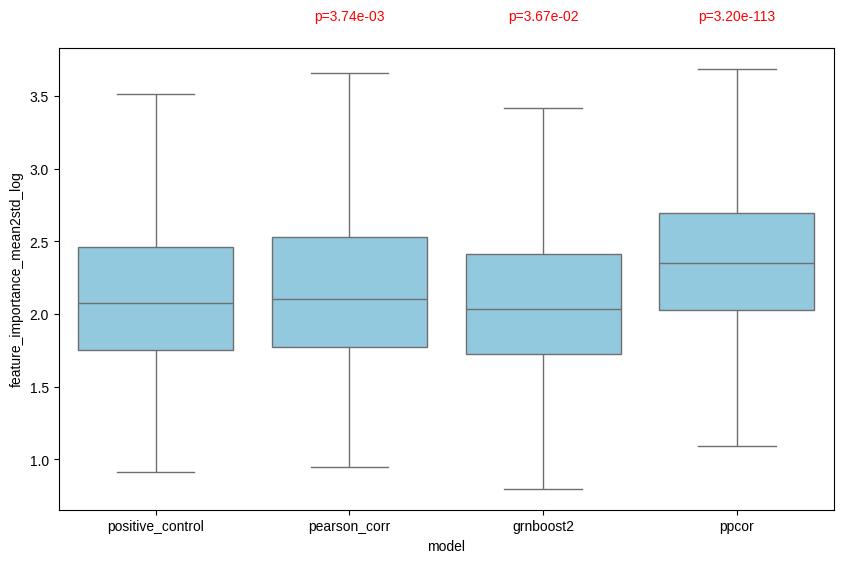

In [98]:
from scipy.stats import mannwhitneyu

scores_store_sub = scores_store_present
df_common_pivot = scores_store_sub.pivot(index=['model'], columns=['donor_id','gene'], values='feature_importance_mean2std').dropna(axis=1)
common_genes = df_common_pivot.columns.get_level_values('gene').unique()

df = df_common_pivot


# Reference row
ref = df_common_pivot.loc['positive_control']

# Perform Mann-Whitney U test for each row
p_values = {}
for row_name, row_data in df_common_pivot.iterrows():
    if row_name != 'positive_control':
        stat, p_value = mannwhitneyu(row_data, ref, alternative='two-sided')
        p_values[row_name] = p_value

# Create a box plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Create box plot using seaborn
import seaborn as sns
sns.boxplot(data=scores_store_sub, x='model', y='feature_importance_mean2std_log', ax=ax, color="skyblue", showfliers=False)

# # Annotate the p-values above the boxes
i = 1
for _, row_name in enumerate(df_common_pivot.index):
    p_value = p_values.get(row_name, None)
    if p_value is not None:
        p_value = p_value*df_common_pivot.shape[0]
        plt.text(
            i,  # x-coordinate
            4,  # Position above the highest point in the box
            f"p={p_value:.2e}",  # Format p-value in scientific notation
            ha='center',
            va='bottom',
            fontsize=10,
            color='red'
        )
        i+=1

# # Set plot aesthetics
# plt.title('Distribution of Data with P-Values from Rank Sum Test')
# plt.xlabel('Rows')
# plt.ylabel('Data')
# plt.xticks(rotation=45)
# plt.axhline(0.05, color='red', linestyle='--', label='Significance threshold (p=0.05)')
# plt.legend()
# plt.tight_layout()

### Distribution of gene-wise r2 scores

<Axes: xlabel='model', ylabel='feature_importance_mean2std_log'>

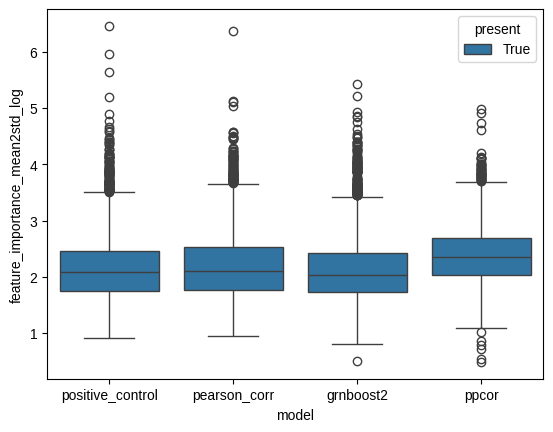

In [67]:
# - random choice of regulators versus informed 
scores_store_present = scores_store[scores_store['present']]
scores_store_present = scores_store_present[scores_store_present['gene'].isin(common_genes)]
sns.boxplot(scores_store_present, x = 'model', y='feature_importance_mean2std_log', hue='present')

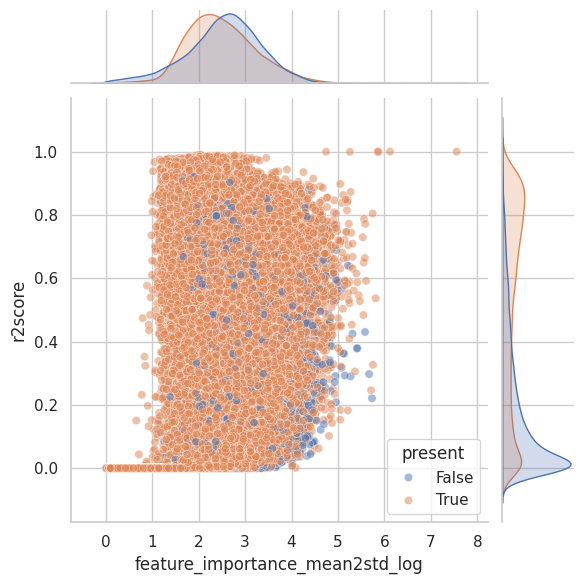

In [211]:
sns.jointplot(
        data = scores_store, 
        x = 'feature_importance_mean2std_log', 
        y = 'r2score', 
        hue= 'present',   # Color points by "True"/"False"
        # markers=True,
        # kind="kde",    # Contours with kde
        # fill=False,    # Fill contour lines
        marginal_kws=dict(common_norm=False, fill=True),  # Marginal distribution,
        alpha=.5
    )

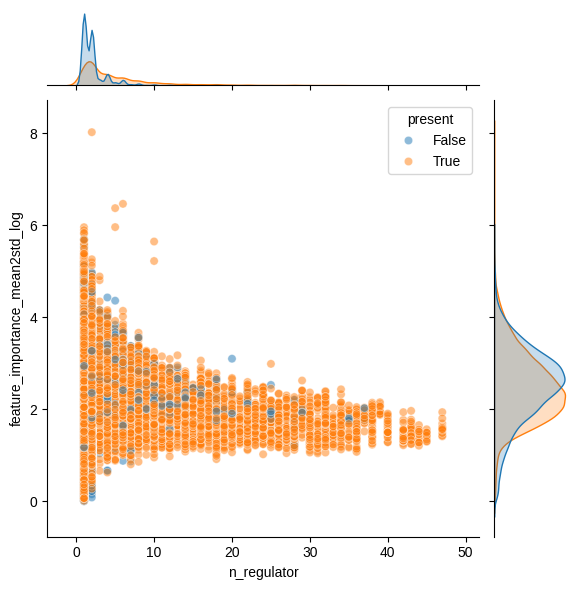

In [27]:
sns.jointplot(
        data = scores_store, 
        x = 'n_regulator', 
        y = 'feature_importance_mean2std_log', 
        hue= 'present',   # Color points by "True"/"False"
        # markers=True,
        # kind="kde",    # Contours with kde
        # fill=False,    # Fill contour lines
        marginal_kws=dict(common_norm=False, fill=True),  # Marginal distribution,
        alpha=.5,
        # s=1
    )

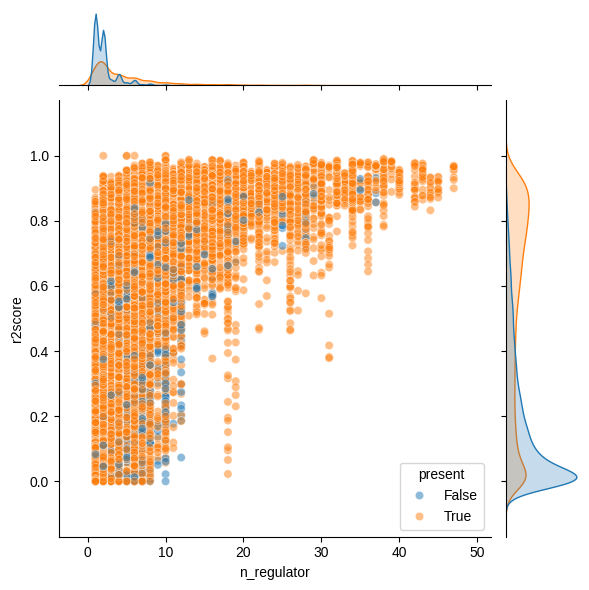

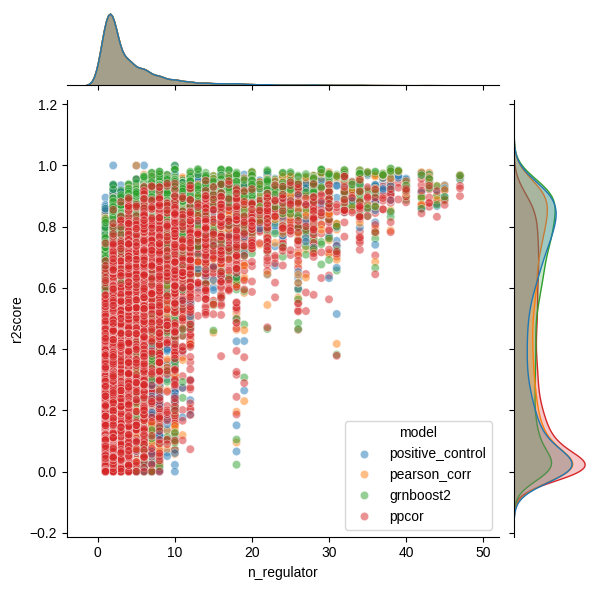

In [74]:
sns.jointplot(
        data = scores_store, 
        x = 'n_regulator', 
        y = 'r2score', 
        hue= 'present',   # Color points by "True"/"False"
        # markers=True,
        # kind="kde",    # Contours with kde
        # fill=False,    # Fill contour lines
        marginal_kws=dict(common_norm=False, fill=True),  # Marginal distribution,
        alpha=.5
    )
sns.jointplot(
        data = scores_store, 
        x = 'n_regulator', 
        y = 'r2score', 
        hue= 'model',   # Color points by "True"/"False"
        # markers=True,
        # kind="kde",    # Contours with kde
        # fill=False,    # Fill contour lines
        marginal_kws=dict(common_norm=False, fill=True),  # Marginal distribution,
        alpha=.5
    )

In [170]:
scores_store[['donor_id', 'r2score', 'model', 'gene']].pivot(
            index=['model'], 
            values='r2score', 
            columns=['gene','donor_id']
        )

gene                   A2M   A2M-AS1      AAK1      AAMP      AARS      AATF  \
donor_id           donor_0   donor_0   donor_0   donor_0   donor_0   donor_0   
model                                                                          
grnboost2         0.534613  0.883860  0.680418  0.117599  0.382307  0.032605   
pearson_corr      0.502886  0.892154  0.554490  0.000000  0.060696  0.023559   
positive_control  0.417528  0.126952  0.198972  0.000000  0.139342  0.054956   
ppcor             0.520719  0.886823  0.085981  0.000000  0.225705  0.013031   

gene                 ABCA1     ABCA5     ABCB1     ABCB4  ...    ZNHIT3  \
donor_id           donor_0   donor_0   donor_0   donor_0  ...   donor_2   
model                                                     ...             
grnboost2         0.862342  0.403389  0.757061  0.756889  ...  0.459379   
pearson_corr      0.828811  0.503193  0.419755  0.776880  ...  0.113216   
positive_control  0.539891  0.277074  0.157294  0.035494  ...  0.593027   
ppcor             0.719386  0.175458  0.190431  0.739652  ...  0.323746   

gene                 ZNRD1     ZNRF2    ZRANB2     ZRSR2   ZSCAN18    ZSWIM6  \
donor_id           donor_2   donor_2   donor_2   donor_2   donor_2   donor_2   
model                                                                          
grnboost2         0.344313  0.866033  0.732321  0.249212  0.580847  0.816856   
pearson_corr      0.434819  0.853150  0.579823  0.049346  0.344683  0.802855   
positive_control  0.630353  0.851244  0.819741  0.157612  0.579119  0.732277   
ppcor             0.176720  0.710703  0.658391  0.257134  0.200206  0.770050   

gene                  ZXDC       ZYX     ZZEF1  
donor_id           donor_2   donor_2   donor_2  
model                                           
grnboost2         0.004419  0.832896  0.308663  
pearson_corr      0.000000  0.845284  0.245358  
positive_control  0.032226  0.858650  0.100279  
ppcor             0.000000  0.677199  0.242324  

[4 rows x 16179 columns]

In [71]:
scores_store[~scores_store['present']][['donor_id', 'r2score', 'model', 'gene']].pivot(
            index='donor_id', 
            values='r2score', 
            columns=['model', 'gene']
        ).T.corr(method='spearman')

donor_id   donor_0   donor_1   donor_2
donor_id                              
donor_0   1.000000  0.529501  0.574873
donor_1   0.529501  1.000000  0.523111
donor_2   0.574873  0.523111  1.000000

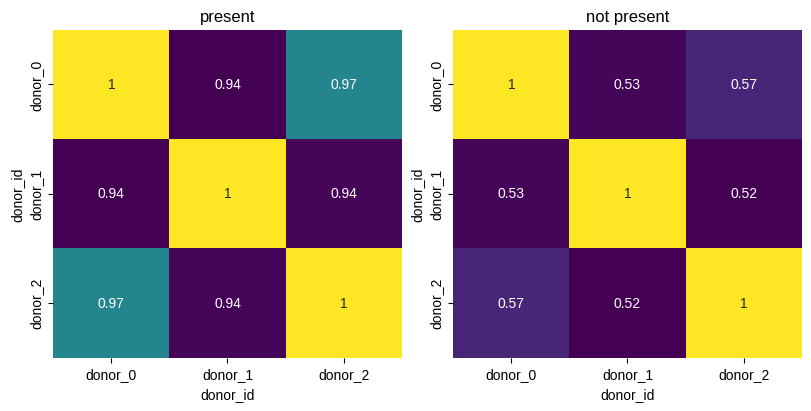

In [73]:
# - consistency in r2 scores among donors
if dataset in ['op']:
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

    # Loop over the regression types and plot each heatmap on a separate subplot
    ax = axes[0]
    # Create pivot table
    scores_store_table = scores_store[scores_store['present']][['donor_id', 'r2score', 'model', 'gene']].pivot(
        index='donor_id', 
        values='r2score', 
        columns=['model', 'gene']
    )
    
    # Calculate the Spearman correlation matrix
    corr_matrix = scores_store_table.T.corr(method='spearman')
    
    # Plot heatmap on the appropriate subplot axis
    sns.heatmap(corr_matrix, annot=True, cmap="viridis", cbar=False, ax=ax)
    ax.set_title(f'present')

    ax = axes[1]
    # Create pivot table
    scores_store_table = scores_store[~scores_store['present']][['donor_id', 'r2score', 'model', 'gene']].pivot(
        index='donor_id', 
        values='r2score', 
        columns=['model', 'gene']
    )
    
    # Calculate the Spearman correlation matrix
    corr_matrix = scores_store_table.T.corr(method='spearman')
    
    # Plot heatmap on the appropriate subplot axis
    sns.heatmap(corr_matrix, annot=True, cmap="viridis", cbar=False, ax=ax)
    ax.set_title(f'not present')

    # Show the plot
    plt.show()


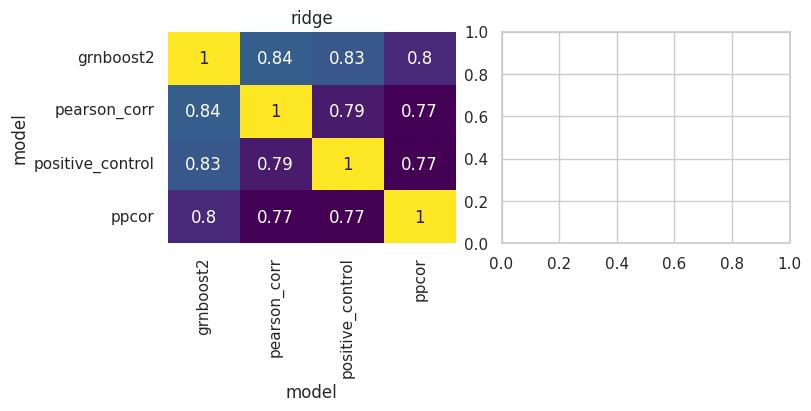

In [171]:
# - consistency in r2 scores among models
if dataset in ['op']:
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

    # Loop over the regression types and plot each heatmap on a separate subplot
    for idx, reg_type in enumerate(['ridge']):
        # Create pivot table
        scores_store_table = scores_store[['donor_id', 'r2score', 'model', 'gene']].pivot(
            index='model', 
            values='r2score', 
            columns=['donor_id', 'gene']
        )
        
        # Calculate the Spearman correlation matrix
        corr_matrix = scores_store_table.T.corr(method='spearman')
        
        # Plot heatmap on the appropriate subplot axis
        sns.heatmap(corr_matrix, annot=True, cmap="viridis", cbar=False, ax=axes[idx])
        axes[idx].set_title(f'{reg_type}')

    # Show the plot
    plt.show()

In [155]:
# - corr of scores across models
# scores_store.pivot(index='model', columns='gene', values='r2score').T.corr()

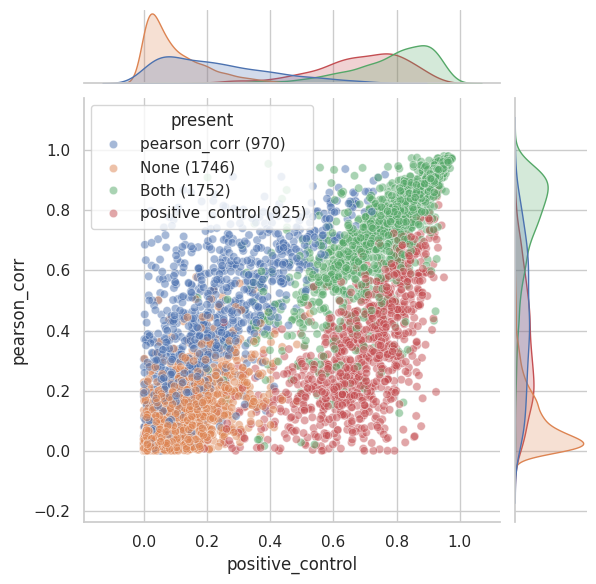

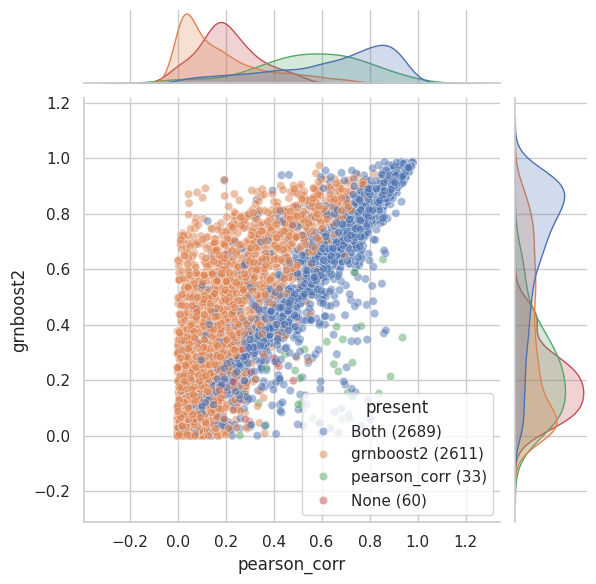

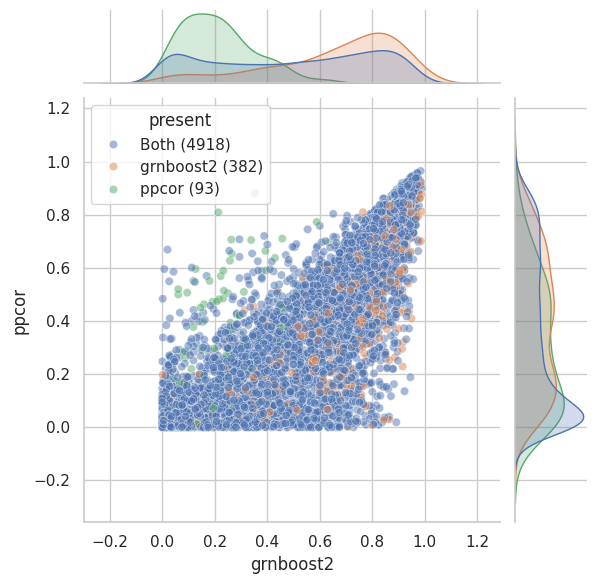

In [154]:
def plot_joint_gene_scores(method1, method2):
    
    scores_store_table = scores_store.pivot_table(index='gene', columns='model', values='r2score', aggfunc='mean')

    # - add common gene specs 
    present_table = scores_store.pivot_table(index='gene', columns='model', values='present', aggfunc='mean')
    present_table = present_table.astype(bool)

    scores_store_table['present'] = 'None'
    scores_store_table.loc[present_table[method1], 'present'] = method1
    scores_store_table.loc[present_table[method2], 'present'] = method2
    scores_store_table.loc[present_table[method1]&present_table[method2], 'present'] = 'Both'


    for name in ['None', method1, method2, 'Both']:
        mask = scores_store_table['present'] == name
        n = (mask).sum()
        scores_store_table.loc[mask, 'present'] += f' ({n})'

    sns.jointplot(
            data = scores_store_table, 
            x = method1, 
            y = method2, 
            hue= 'present',   # Color points by "True"/"False"
            # markers=True,
            # kind="kde",    # Contours with kde
            # fill=False,    # Fill contour lines
            marginal_kws=dict(common_norm=False, fill=True),  # Marginal distribution,
            alpha=.5
        )
    return scores_store_table
scores_store_table = plot_joint_gene_scores(par['grn_models'][0], par['grn_models'][1])
scores_store_table = plot_joint_gene_scores(par['grn_models'][1], par['grn_models'][2])
scores_store_table = plot_joint_gene_scores(par['grn_models'][2], par['grn_models'][3])



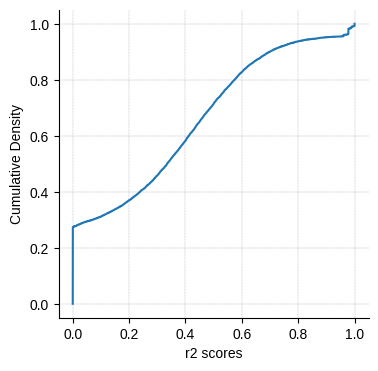

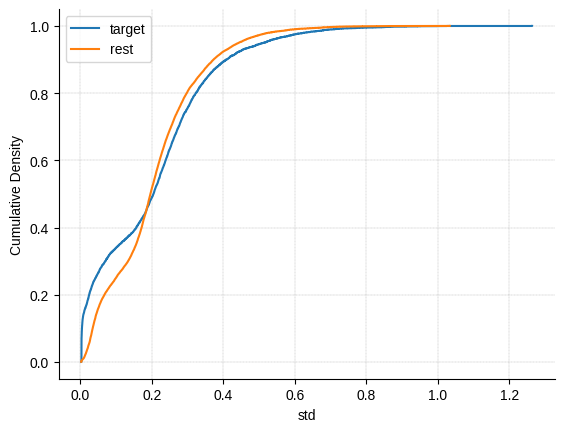

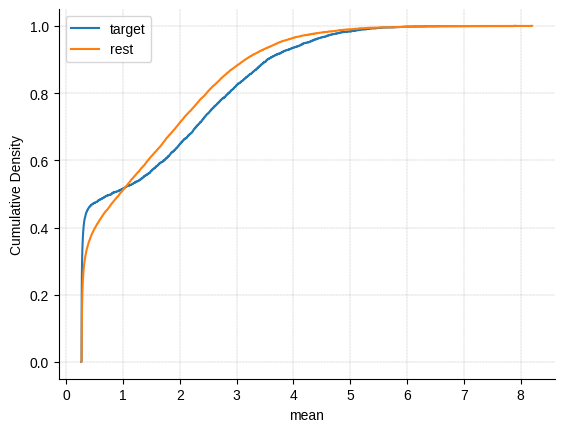

In [59]:
# - evaluation of common genes
common_genes_all = interaction_info['target'][interaction_info['target'].all(axis=1)].index
mask_genes = perturb_data.var_names.isin(common_genes_all)
X_target = perturb_data.X[:, mask_genes]
X_rest = perturb_data.X[:, ~mask_genes]

plot_cumulative_density(scores_store[scores_store.gene.isin(common_genes_all)].r2score, x_label='r2 scores')


fig, ax = plt.subplots(1,1)
plot_cumulative_density(np.std(X_target, axis=0), ax=ax, label='target', x_label='std')
plot_cumulative_density(np.std(X_rest, axis=0), ax=ax, label='rest',x_label='std')
plt.legend()

fig, ax = plt.subplots(1,1)
plot_cumulative_density(np.mean(X_target, axis=0), ax=ax, label='target', x_label='mean')
plot_cumulative_density(np.mean(X_rest, axis=0), ax=ax, label='rest',x_label='mean')
plt.legend()

In [52]:
# - enrichment analysiss
enr = gp.enrichr(gene_list=list(common_genes_all),
                 gene_sets= ['TRANSFAC_and_JASPAR_PWMs'], #,['GO_Biological_Process_2021', 'KEGG_2021_Human'], MSigDB_Hallmark_2020, PanglaoDB_Augmented_2021, ChEA_2016
                 organism='Human',  # change to 'Mouse' or other organism if needed
                 outdir=None)  # No output files

# View results as a DataFrame
results_df = enr.results

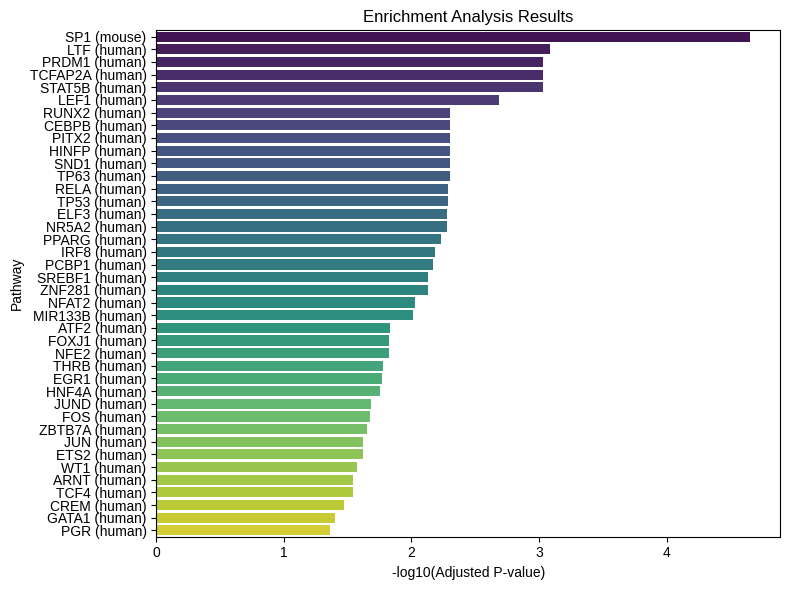

In [53]:
def plot_enrichment(df):
    # Calculate -log10 of Adjusted P-value for a clearer visualization
    df['-log10(Adjusted P-value)'] = -np.log10(df['Adjusted P-value'])
    

    # Sort the DataFrame by significance (optional)
    df = df.sort_values(by='-log10(Adjusted P-value)', ascending=False)

    # Plotting the enrichment analysis
    plt.figure(figsize=(8, 6))
    sns.barplot(data=df, y='Term', x='-log10(Adjusted P-value)', palette="viridis")

    # Add plot labels and title
    plt.xlabel("-log10(Adjusted P-value)")
    plt.ylabel("Pathway")
    plt.title("Enrichment Analysis Results")
    plt.tight_layout()
df = results_df[results_df['Adjusted P-value']<.05]
df = df.sort_values(by='Adjusted P-value', ascending=True)[:40]
# print(df)
plot_enrichment(df)

In [54]:
if False:
    # - mean of feature importance across CVs
    mean_coeff = pd.DataFrame(
        np.mean(coeffs, axis=0),
        columns=net_mat.columns,
        index=pd.MultiIndex.from_frame(obs[['perturbation', 'cell_type']])
    )    
    # - normalize feature importance for each sample
    mean_coeff = mean_coeff.abs()
    mean_coeff = mean_coeff.div(mean_coeff.max(axis=1), axis=0)

    # - long df for feature importance 
    mean_coeff  = mean_coeff.reset_index()
    mean_coeff = mean_coeff.melt(id_vars=['perturbation', 'cell_type'], var_name='tf', value_name='feature_importance')
    mean_coeff['model'] = model
    mean_coeff['donor_id'] = donor_id
    mean_coeff['reg_type'] = reg_type

In [13]:
# main(par={
#   "evaluation_data": f"{task_grn_inference_dir}/resources/evaluation_datasets/op_perturbation.h5ad",
#   "tf_all": f"{task_grn_inference_dir}/resources/prior/tf_all.csv",
#   # "prediction": "output/pearson_net.csv",
#   "prediction": f"{task_grn_inference_dir}/resources/grn_models/op/pearson_corr.csv",
#   "method_id": "scenic",
#   "max_n_links": 50000,
#   "apply_tf": False,
#   'score': 'output/score.h5ad',
#   'reg_type': 'ridge',
#   'layer': 'pearson',
#   'subsample': -1,
#   'num_workers': 4,
#   'skeleton': 'resources/prior/skeleton.csv',
#   'apply_skeleton': False,
#   'verbose': 4,
#   'binarize': True
# })

- sample based and gene based predictions scores, for reg1 and 2, respectively -> three top models
- feature activation for different CVs. sample based and gene 
- variability across donors 
- different alphas


### Feature importance analysis


# Topological analysis

In [30]:
exp_objs_dict_dict = {}
for dataset in datasets:
# dataset = 'op' #'op', nakatake, adamson
    par = {
        
            'grn_models': ['negative_control', 'positive_control', 'pearson_corr', 'ppcor', 'portia', 'grnboost2', 'scenic', 'scglue', 'celloracle', 'figr', 'granie', 'scenicplus'],
            # 'grn_models': [ 'positive_control', 'pearson_corr', 'grnboost2', 'scenicplus', 'celloracle'],
            'shortlist': ['pearson_corr', 'ppcor', 'portia', 'grnboost2'],

            'peak_gene_models': ['celloracle', 'scenicplus', 'figr', 'granie'],
            'grn_models_dir': f'{task_grn_inference_dir}/resources/grn_models/{dataset}/',
            'peak_gene_dir': f'{task_grn_inference_dir}/resources/grn_models/{dataset}/peak_gene/',
    }

    exp_objs_dict = {}
    nets_dict = {}

    for model in par['grn_models']:
        par['grn_model'] = f"{par['grn_models_dir']}/{model}.csv"
        if not os.path.exists(par['grn_model']):
            print(model, ' is skipped')
            continue
        net = pd.read_csv(par['grn_model'])

        net = net.drop_duplicates()
        
        nets_dict[model] = net

        if model in par['peak_gene_models']:
            peak_gene_net = pd.read_csv(f"{par['peak_gene_dir']}/{model}.csv")
        else:
            peak_gene_net = None
        print(model, len(net))
        obj = Exp_analysis(net, peak_gene_net)
        obj.calculate_basic_stats()
        obj.calculate_centrality()

        exp_objs_dict[model] = obj
    exp_objs_dict = {surragate_names[key]:value for key,value in exp_objs_dict.items()}
    exp_objs_dict_dict[dataset] = exp_objs_dict

negative_control 50000
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic 64489
scglue 7227
celloracle 50000
figr 52962
granie 50000
scenicplus 41288
negative_control 50000
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic 18031
scglue  is skipped
celloracle  is skipped
figr  is skipped
granie  is skipped
scenicplus  is skipped
negative_control 50000
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic 99500
scglue  is skipped
celloracle  is skipped
figr  is skipped
granie  is skipped
scenicplus  is skipped
negative_control 28163
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic 2182
scglue  is skipped
celloracle  is skipped
figr  is skipped
granie  is skipped
scenicplus  is skipped
negative_control 50000
positive_control 50000
pearson_corr 50000
ppcor 50000
portia 50000
grnboost2 50000
scenic  is skipped
scglue  is skipped
cellorac

## General stats

In [31]:
for i, dataset in enumerate(datasets):
    exp_objs_dict = exp_objs_dict_dict[dataset]
    # regulatory links
    links_n = {}
    source_n = {}
    target_n = {}
    nets = {}

    for name, obj in exp_objs_dict.items():
        net = obj.net
        if 'cell_type' in net.columns: # for cell specific grn models, take the mean
            n_grn = net.groupby('cell_type').size().mean()
        else:
            n_grn = len(net)

        links_n[name] = n_grn
        source_n[name] = obj.stats['n_source']
        target_n[name] = obj.stats['n_target']
    # Prepare data for plotting
    data = {
        'Model': [],
        'Count': [],
        'Type': []
    }

    # Populate the data dictionary for each metric
    for model in links_n.keys():
        data['Model'].append(model)
        data['Count'].append(links_n[model])
        data['Type'].append('Putative links')

    for model in source_n.keys():
        data['Model'].append(model)
        data['Count'].append(source_n[model])
        data['Type'].append('Putative TFs')

    for model in target_n.keys():
        data['Model'].append(model)
        data['Count'].append(target_n[model])
        data['Type'].append('Putative target genes')

    # Create a DataFrame from the data dictionary
    df = pd.DataFrame(data)
    df['Dataset'] = dataset
    if i == 0:
        df_all =df
    else:
        df_all = pd.concat([df_all, df]).reset_index(drop=True)


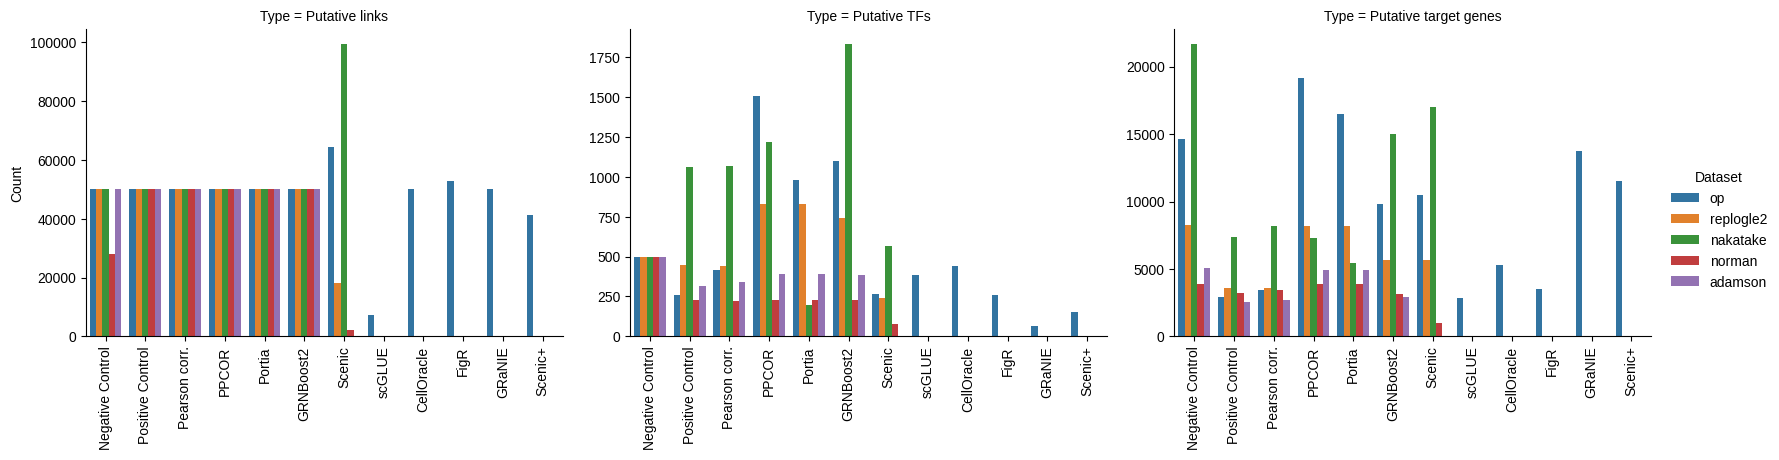

In [32]:
g = sns.catplot(
    data=df_all, 
    x='Model', 
    y='Count', 
    hue='Dataset', 
    col='Type', 
    kind='bar', 
    height=4, 
    aspect=1.4, 
    legend_out=True, 
    sharey=False
)
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
    ax.set_xlabel('')
plt.show()

In [33]:
    # print(df)
    # aa

    # # Create the FacetGrid for separate y-axes
    # g = sns.FacetGrid(df, col='Type', height=3.5, aspect=1, sharey=False)

    # # Map the bar plot to each facet
    # g.map_dataframe(sns.barplot, x='Model', hue='Model', y='Count', palette=color_map_methods, alpha=0.9)

    # # Customize the plot
    # g.set_xticklabels(rotation=90)
    # g.set_axis_labels("", "Count")
    # # g.fig.suptitle("Gene Regulatory Network Statistics", y=1.05)

    # # Use ax.margins to set margins on the x-axis
    # for ax in g.axes.flat:
    #     ax.margins(x=0.05)  # Adjust the margin fraction as needed

    # # Remove the default titles and set custom titles without 'Type='
    # prefixes = ['(a)', '(b)', '(c)']
    # for i, ax in enumerate(g.axes.flat):
    #     title = ax.get_title().replace('Type = ', f'{prefixes[i]}: ').strip()  # Remove 'Type='
    #     ax.set_title(title, pad=20, fontsize=10, fontweight='bold')

    # # Remove spines for better aesthetics
    # for ax in g.axes.flat:
    #     ax.spines['right'].set_visible(False)
    #     ax.spines['top'].set_visible(False)
    # plt.suptitle(surragate_names[dataset], fontsize=12, fontweight='bold')
    # plt.tight_layout()
    # # plt.savefig(f'{results_folder}/explanatory_analysis/figs/stats_{dataset}.png', dpi=300, transparent=True)


## Network density 

Text(0.5, 1.1, 'In-degree centrality')

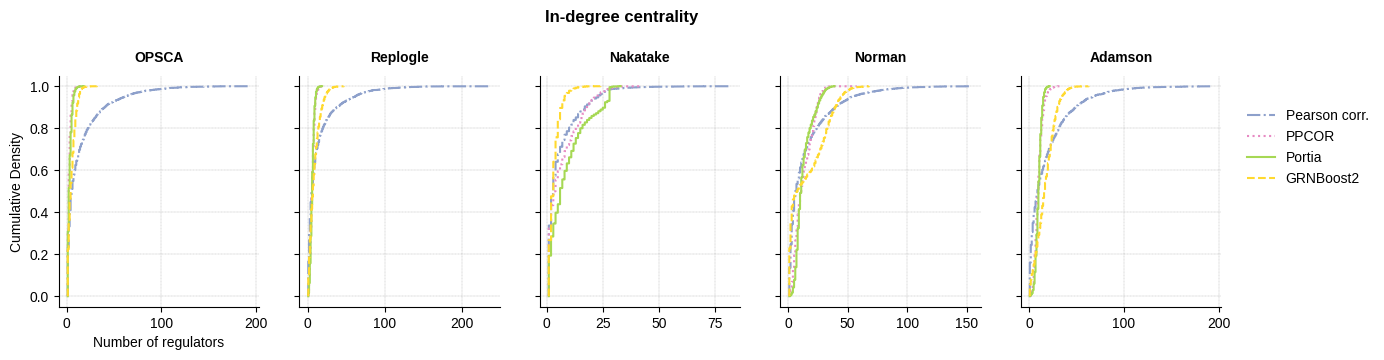

In [34]:
# tf gene: in degree
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True)
for i, dataset in enumerate(datasets):
    ax = axes[i]
    exp_objs_dict = exp_objs_dict_dict[dataset]
    for name in par['shortlist']:
        name = surragate_names.get(name,name)
        obj = exp_objs_dict[name]
        obj.calculate_centrality()
        values = obj.tf_gene.in_deg.degree.values

        obj.plot_cumulative_density(values, title='', x_label='Number of regulators', ax=ax, alpha=1, label=name, s=5, c=color_map_methods[name], linestyle=linestyle_map_methods[name])
        
        # ax.set_xlim([-5, 250])
        # ax.set_title('(a) In-degree centrality: TF-gene', pad=20)
    # plt.tight_layout()
    if i != 0:
        ax.set_ylabel('')
        ax.set_xlabel('')
    ax.set_title(surragate_names[dataset], pad=10, fontsize=10, fontweight='bold')

plt.legend(frameon=False, loc=(1.1, .5))
plt.suptitle('In-degree centrality', y=1.1, fontsize=12, fontweight='bold')

# fig.savefig(f'{results_folder}/explanatory_analysis/figs/centrality_in.png', dpi=300, transparent=True,  bbox_inches='tight')

## Regulatory signs

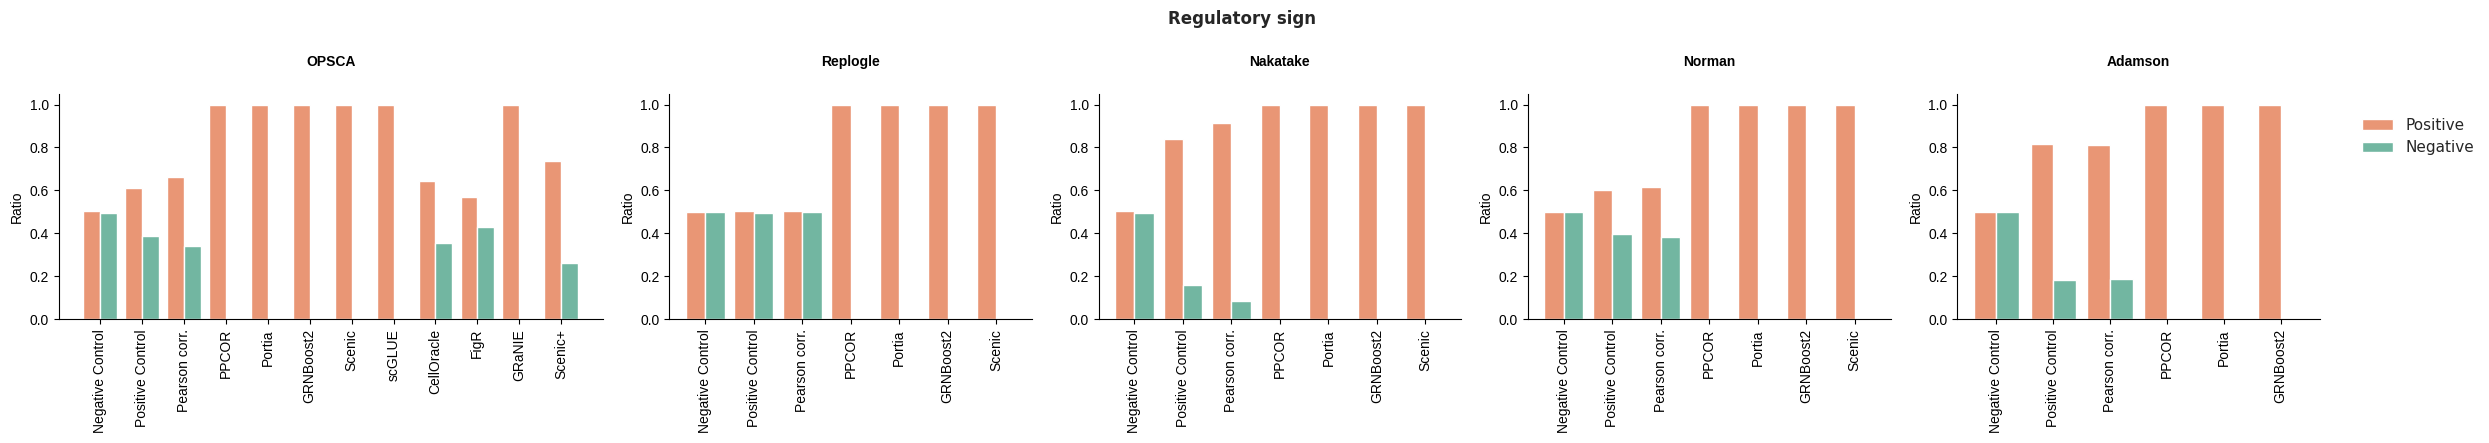

In [35]:
fig, axes = plt.subplots(1, len(datasets), figsize=(5*len(datasets), 4.5),   gridspec_kw={'width_ratios': [1.5, 1, 1, 1, 1]}  # Custom width ratios
)
for i, dataset in enumerate(datasets):
    ax = axes[i]
    exp_objs_dict = exp_objs_dict_dict[dataset]

    ratio_positive_negative_dict = {}

    for name, obj in exp_objs_dict.items():
        ratio_positive_negative_dict[name] = obj.stats['ratio_positive_negative']
    # ratio_positive_negative_dict[name] = obj.stats['ratio_positive_negative']

    data = ratio_positive_negative_dict
    models = list(data.keys())
    positive_r = [p for p in data.values()]
    negative_r = [1 - p for p in data.values()]


    df = pd.DataFrame({
        'Model': models * 2,  # Repeat model names for both Positive and Negative
        'Ratio': positive_r + negative_r,  # Concatenate positive and negative ratios
        'Regulatory Sign': ['Positive'] * len(models) + ['Negative'] * len(models)  # Label each as Positive or Negative
    })

    # Set Seaborn theme
    sns.set(style="whitegrid")  
    
    sns.barplot(x='Model', y='Ratio', hue='Regulatory Sign', data=df, width=.8,
                palette=[list(color_map_methods.values())[1], list(color_map_methods.values())[0]], ax=ax)

    # Customize labels and ticks
    ax.set_ylabel('Ratio')
    ax.tick_params(axis='x', rotation=90)
    ax.margins(x=0.05)
    ax.set_xlabel('')
    ax.set_title(surragate_names[dataset], pad=20, fontsize=10, fontweight='bold')


    # Remove top and right spines
    sns.despine(ax=ax, top=True, right=True)

    ax.get_legend().remove()

    # Grid and legend
    # ax.grid(alpha=0.3, linestyle='--', linewidth=.5, color='grey')
    

plt.suptitle('Regulatory sign', fontsize=12, fontweight='bold')
plt.legend(frameon=False, loc=(1.1, .7))
plt.tight_layout()
# plt.savefig(f'{results_folder}/explanatory_analysis/figs/regulatory_signs.png', dpi=300, transparent=True)


## Interactions 

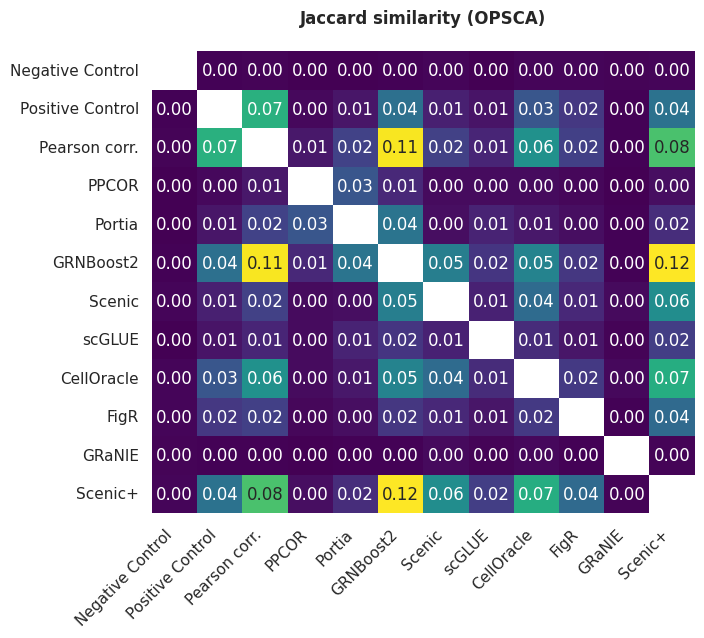

In [42]:
for i, dataset in enumerate(['op']):
    ax = axes[i]
    exp_objs_dict = exp_objs_dict_dict[dataset]
    nets = {}
    for name, obj in exp_objs_dict.items():
        nets[name] = obj.net
        
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    _ = jaccard_similarity_net(nets, ax=ax)

    ax.set_title(f'Jaccard similarity ({surragate_names[dataset]})', pad=20, fontsize=12, fontweight='bold')
    # plt.savefig(f'{results_folder}/explanatory_analysis/figs/jaccard_similarity_{dataset}.png', dpi=300, transparent=True, bbox_inches='tight')


['PPCOR', 'Portia', 'GRNBoost2', 'Pearson corr.']
['Portia', 'PPCOR', 'GRNBoost2', 'Pearson corr.']
['GRNBoost2', 'Pearson corr.', 'PPCOR', 'Portia']
['Portia', 'PPCOR', 'Pearson corr.', 'GRNBoost2']
['PPCOR', 'Portia', 'GRNBoost2', 'Pearson corr.']


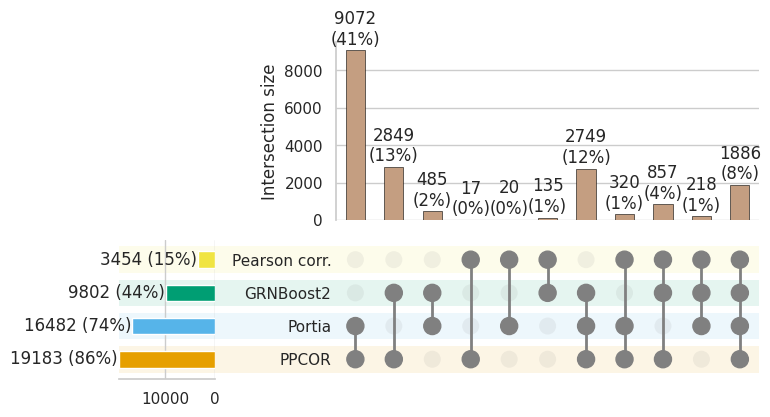

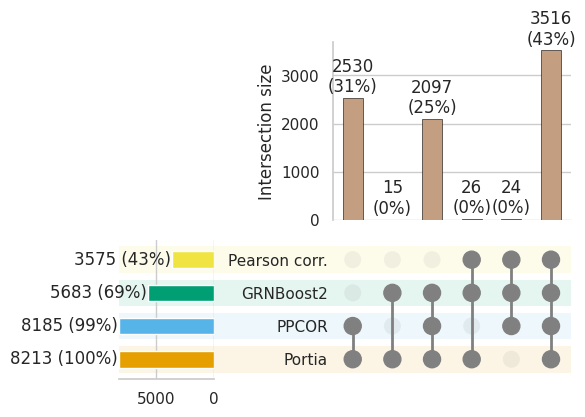

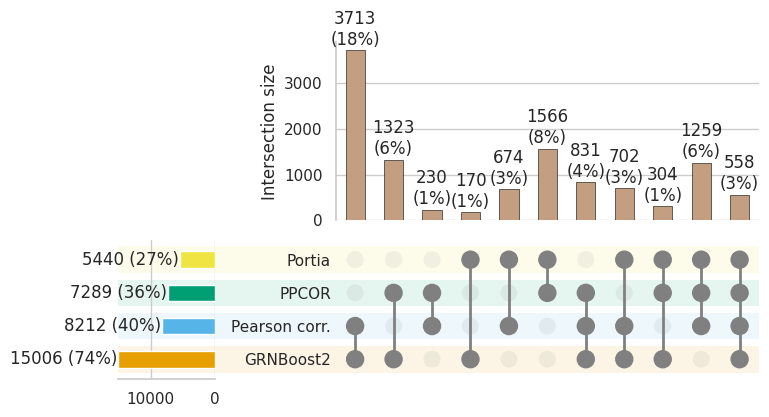

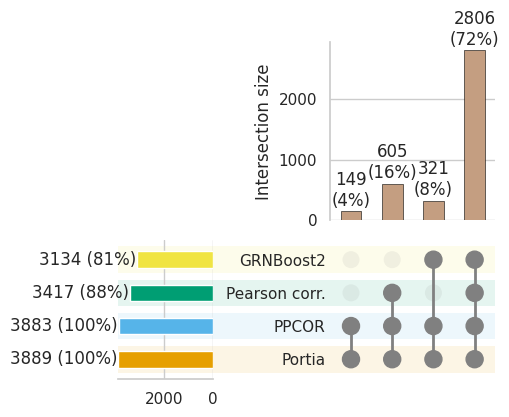

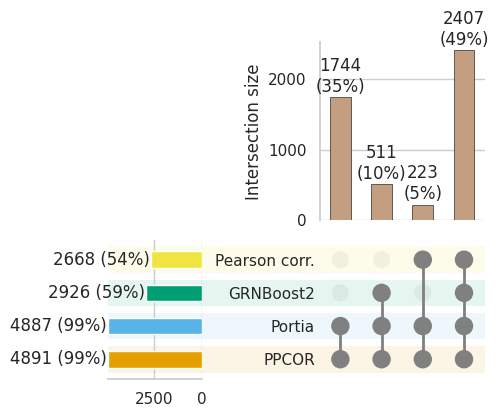

In [52]:
# Create a set of all unique genes
for i, dataset in enumerate(datasets):
    ax = axes[i]
    exp_objs_dict = exp_objs_dict_dict[dataset]

    shortlist_grns =   [surragate_names[key] for key in par['shortlist']]
    interaction_info = create_interaction_info({key:exp_objs_dict[key] for key in shortlist_grns})
    # fig = plot_interactions(interaction_info['links'], min_subset_size = 1000, min_degree=3, color_map=None)    
    # fig.savefig(f'{results_folder}/explanatory_analysis/figs/links_interactions.png', dpi=300, transparent=True,  bbox_inches='tight')
    # fig = plot_interactions(interaction_info['source'], min_subset_size = 10, min_degree=2, color_map=None) 
    # fig.savefig(f'{results_folder}/explanatory_analysis/figs/TFs_interactions.png', dpi=300, transparent=True, bbox_inches='tight')
    fig = plot_interactions(interaction_info['target'], min_subset_size = 10, min_degree=2, color_map=None) 
    # fig.savefig(f'{results_folder}/explanatory_analysis/figs/targets_interactions.png', dpi=300, transparent=True, bbox_inches='tight')

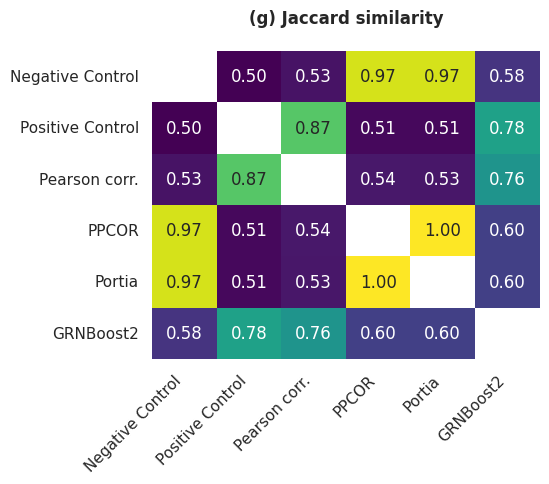

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
_ = jaccard_similarity_net(nets, col_name='target', ax=ax)
ax.set_title('(g) Jaccard similarity', pad=20, fontsize=12, fontweight='bold')
plt.savefig(f'{results_folder}/explanatory_analysis/figs/jaccard_similarity_target_{dataset}.png', dpi=300, transparent=True, bbox_inches='tight')


In [39]:
aaa

NameError: name 'aaa' is not defined

# Skeleton

In [41]:
skeleton =  pd.read_csv(f'{task_grn_inference_dir}/resources/prior/skeleton.csv')
skeleton_promotor = pd.read_csv(f'{task_grn_inference_dir}/resources/prior/skeleton_promotor.csv')

In [60]:
skeleton_promotor['link'] = skeleton_promotor['source'] + '_' + skeleton_promotor['target']

In [48]:
links_promotor = ['_'.join(link.split(',')[1:]) for link in skeleton_promotor]
links_skeleton = ['_'.join(link.split(',')[1:]) for link in skeleton]

In [70]:
ratio_in_skeleton_dict = {}
ratio_in_promotor_dict = {}

for name, obj in exp_objs_dict.items():
    # skeleton 
    net = obj.net[obj.net.target.isin(gene_names)]
    matches = pd.merge(net[['source', 'target']], skeleton[['source', 'target']], 
                   on=['source', 'target'], how='inner')
    in_count = len(matches)
    ratio_in_skeleton_dict[name] = in_count/len(net)
    # promotor 
    matches = pd.merge(net[['source', 'target']], skeleton_promotor[['source', 'target']], 
                   on=['source', 'target'], how='inner')
    in_count = len(matches)
    ratio_in_promotor_dict[name] = in_count/len(net)

KeyboardInterrupt: 

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_96102/1426171357.py:18: UserWarning: The palette list has more values (7) than needed (3), which may not be intended.
  g = sns.barplot(x='Model', y='Ratio', hue='Skeleton Status', data=df, width=.8,


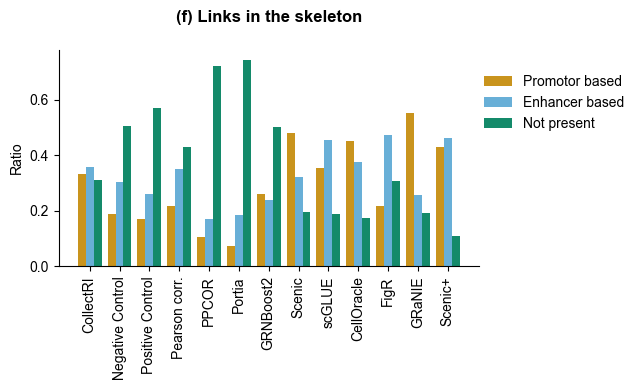

In [69]:
colors = sns.color_palette()
# Data preparation
models = list(ratio_in_skeleton_dict.keys())
in_promotor_r = [p for p in ratio_in_promotor_dict.values()]
in_skeleton_r = [p for p in ratio_in_skeleton_dict.values()]
in_enhancer_r = list(np.array(in_skeleton_r)-np.array(in_promotor_r))
not_in_skeleton_r = [1 - p for p in ratio_in_skeleton_dict.values()]

# Create a DataFrame suitable for Seaborn
df = pd.DataFrame({
    'Model': models * 3,  # Repeat model names for both 'In skeleton' and 'Not in skeleton'
    'Ratio': in_promotor_r + in_enhancer_r + not_in_skeleton_r ,  # Concatenate the positive and negative ratios
    'Skeleton Status': ['Promotor based'] * len(models) +  ['Enhancer based'] * len(models) + ['Not present'] * len(models)  # Label for each bar
})

# Create bar plot using Seaborn
fig, ax = plt.subplots(1, 1, figsize=(6.5, 4))
g = sns.barplot(x='Model', y='Ratio', hue='Skeleton Status', data=df, width=.8,
            palette=colors_blind, ax=ax)

# Customize labels and ticks
ax.set_ylabel('Ratio')
ax.tick_params(axis='x', rotation=90)

# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)

# Grid and legend
ax.legend(frameon=False, loc=(1, .6))
g.axes.margins(x=0.05)
g.axes.set_xlabel('')
ax.set_title('(f) Links in the skeleton', pad=20, fontsize=12, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.savefig(f'{results_folder}/explanatory_analysis/figs/in_skeleton.png', dpi=300, transparent=True)


# Annoation

### Annotate peaks

In [63]:
annotation_df = pd.read_csv(f'{task_grn_inference_dir}/resources/prior/peak_annotation.csv')
annotation_df.head()
for key, obj in exp_objs_dict.items():
    obj.annotate_peaks(annotation_df)

Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Peak gene net is not given. Peak annoation is skipped.
Not all peaks in the net is among the annotated ones. Finding the overlap


#### Plot

In [65]:
annotation_dict = {}
for name, obj in exp_objs_dict.items():
    if obj.peak_annot is not None:
        annotation_dict[name] = obj.peak_annot
peak_annotation_df = pd.DataFrame.from_dict(annotation_dict, orient='index')
threshold = 1 # remove below this raction
peak_annotation_df = peak_annotation_df.loc[:, (peak_annotation_df>threshold).sum(axis=0)!=0]
peak_annotation_df

Promoter  Intron  Distal Intergenic  Exon  3' UTR  \
CellOracle      98.5     0.6                0.3   0.2     0.1   
FigR            30.4    37.8               18.0   6.7     4.7   
GRaNIE          66.2    15.8               10.4   4.0     2.3   
Scenic+         35.1    34.4               17.3   6.8     4.4   

            Downstream (<=300)  
CellOracle                 0.0  
FigR                       1.5  
GRaNIE                     0.9  
Scenic+                    1.2

In [115]:
peak_annotation_df = peak_annotation_df.reindex(['FigR', 'CellOracle', 'GRaNIE', 'Scenic+'])

/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_28270/1104589649.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if counts[j] == 0 or counts[j] < 4:  # Skip annotation for values less than 1%
/var/folders/wb/m4_pk_gd01q4_1mnj5hj153jjfhj_t/T/ipykernel_28270/1104589649.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{counts[j]:.1f}%', xy=(x, y), xytext=(1.2*x, 1.2*y),


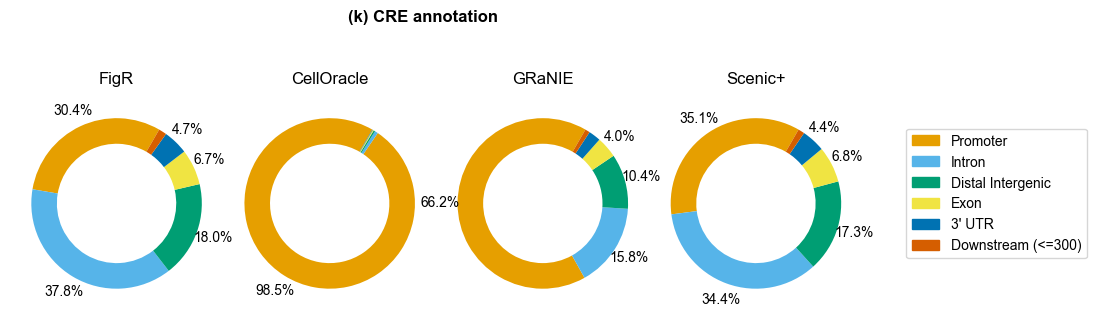

In [182]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

# Create subplots with adjusted width ratios
fig, axes = plt.subplots(1, len(peak_annotation_df.index), figsize=(11, 4))
startangle = 60

# Iterate over pie charts
for i, (ax, idx) in enumerate(zip(axes, peak_annotation_df.index)):
    ax.set_title(idx, fontsize=12, pad=10)
    counts = peak_annotation_df.loc[idx]
    wedges, _ = ax.pie(counts, colors=colors_blind, wedgeprops=dict(width=0.3), startangle=startangle)

    for j, wedge in enumerate(wedges):
        if counts[j] == 0 or counts[j] < 4:  # Skip annotation for values less than 1%
            continue
        # Calculate angle and position for the annotation
        ang = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))
        ax.annotate(f'{counts[j]:.1f}%', xy=(x, y), xytext=(1.2*x, 1.2*y),
                    ha="center", va="center", fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="none", ec="none"))

# Adjust spacing and add legend
plt.subplots_adjust(wspace=0)

# Create a single legend outside the pie charts
patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors_blind, peak_annotation_df.columns)]
fig.legend(handles=patches, loc='center right', bbox_to_anchor=(1.11, 0.52), fontsize=10)

fig.suptitle('(k) CRE annotation', fontsize=12, fontweight='bold')
# Save figure
fig.savefig(f'{results_folder}/explanatory_analysis/figs/peak_annotation.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

# Effect of pseudobulking on performance